## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [3]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [164]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t):
    if sigma_a_2 == 0:
        a = np.zeros(N)
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N)
    v = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    x = np.ones(N) * x_0 + (v * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

def running_mean(z, M, mask=None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

### Parameters

In [91]:
N = 200
sigma_a = 0.2
sigma_n = 20
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[10000, 0], [0,10000]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*sigma_a**2
R = np.array([[sigma_n**2]])
T = np.matrix([[1, t],[0,1]])

# Generating the trajectory $x$

# and measurements $z$

In [5]:
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)

# Presenting the system in matrix form

# and developing Kalman filter

In [73]:
#T - transport matrix
#G - input
#z - measurements
#H - obs
#sigma_n - noise
#sigma_a - acc noise
#R = sigma_n**2 
#P_0 
def kalman(X_0, P_0, z, T, H, R, Q, Kext = None):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    XF= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        print("P")
        print(P[i])
        #Filtration
        if Kext is None:
            tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
            tmp2 = H.transpose().dot(tmp1)
            K[i] = P[i].dot(tmp2)
        else:
            K[i] = Kext[i]
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
        if i + 6 < len(z):
            XF[6 + i] = T6.dot(X[i])
    return X,K,P,XF
        

In [6]:
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)

# Plot results 

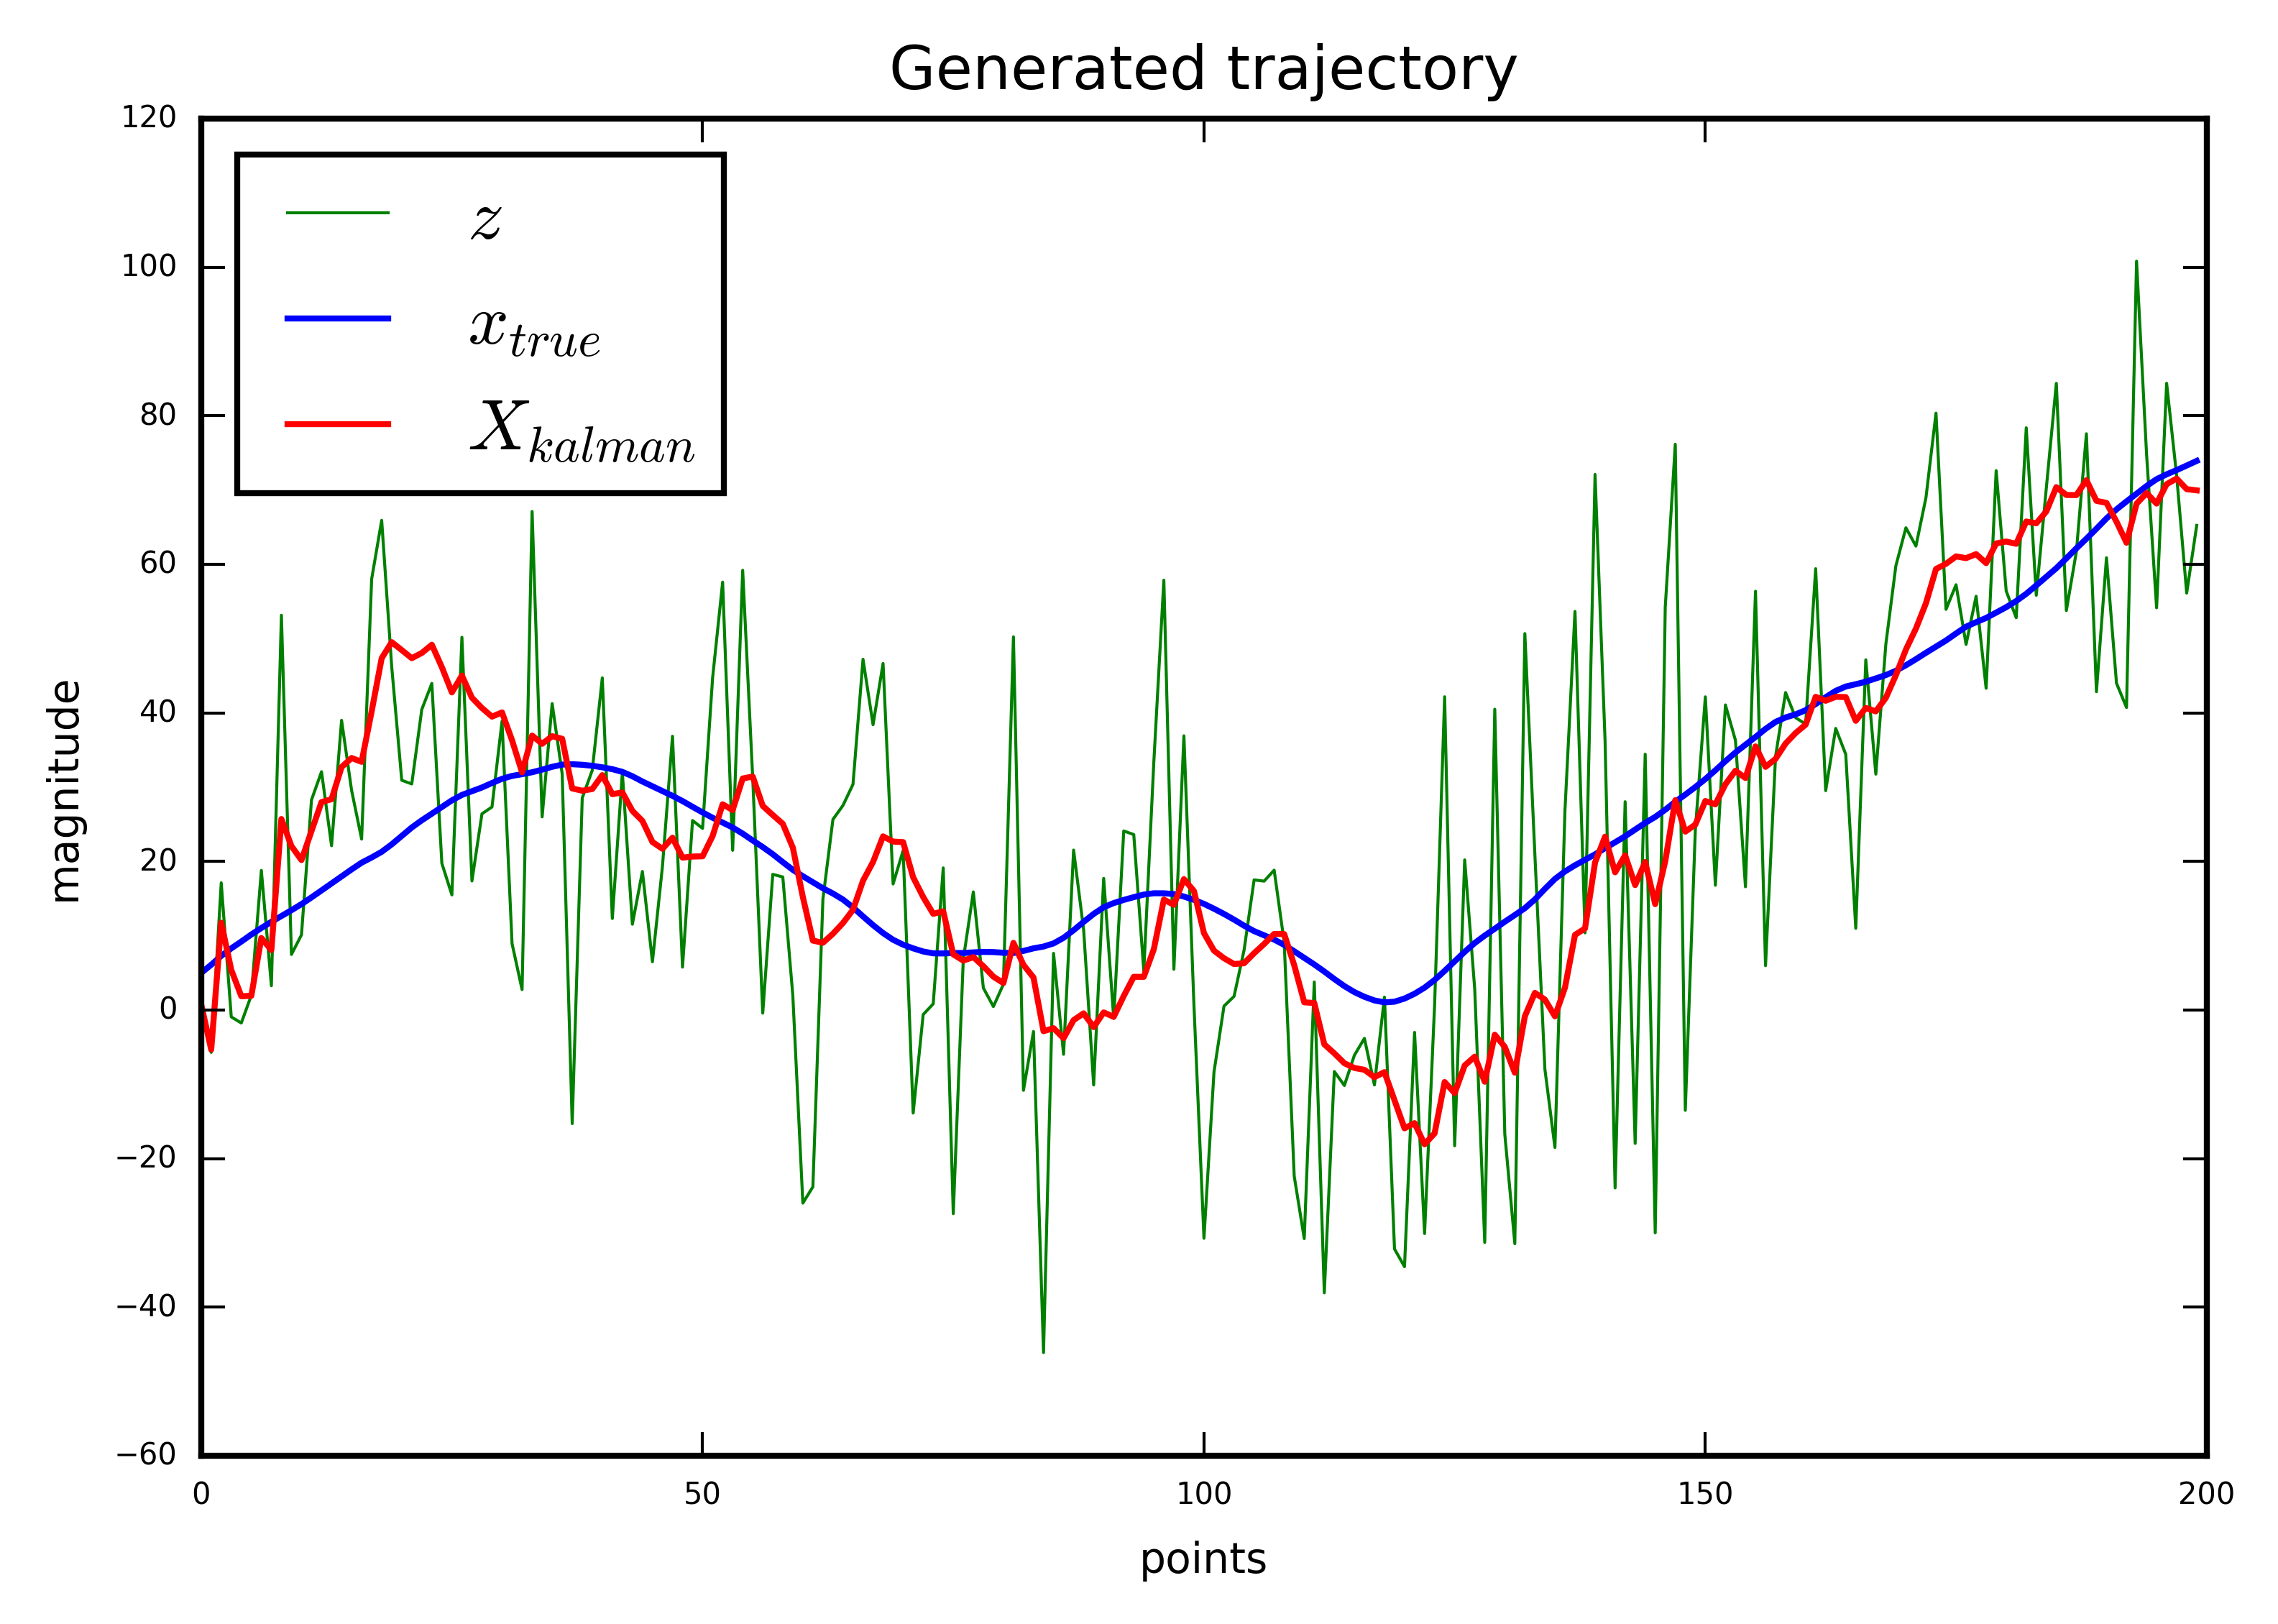

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax.plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.legend(loc='upper left')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

# Plot K

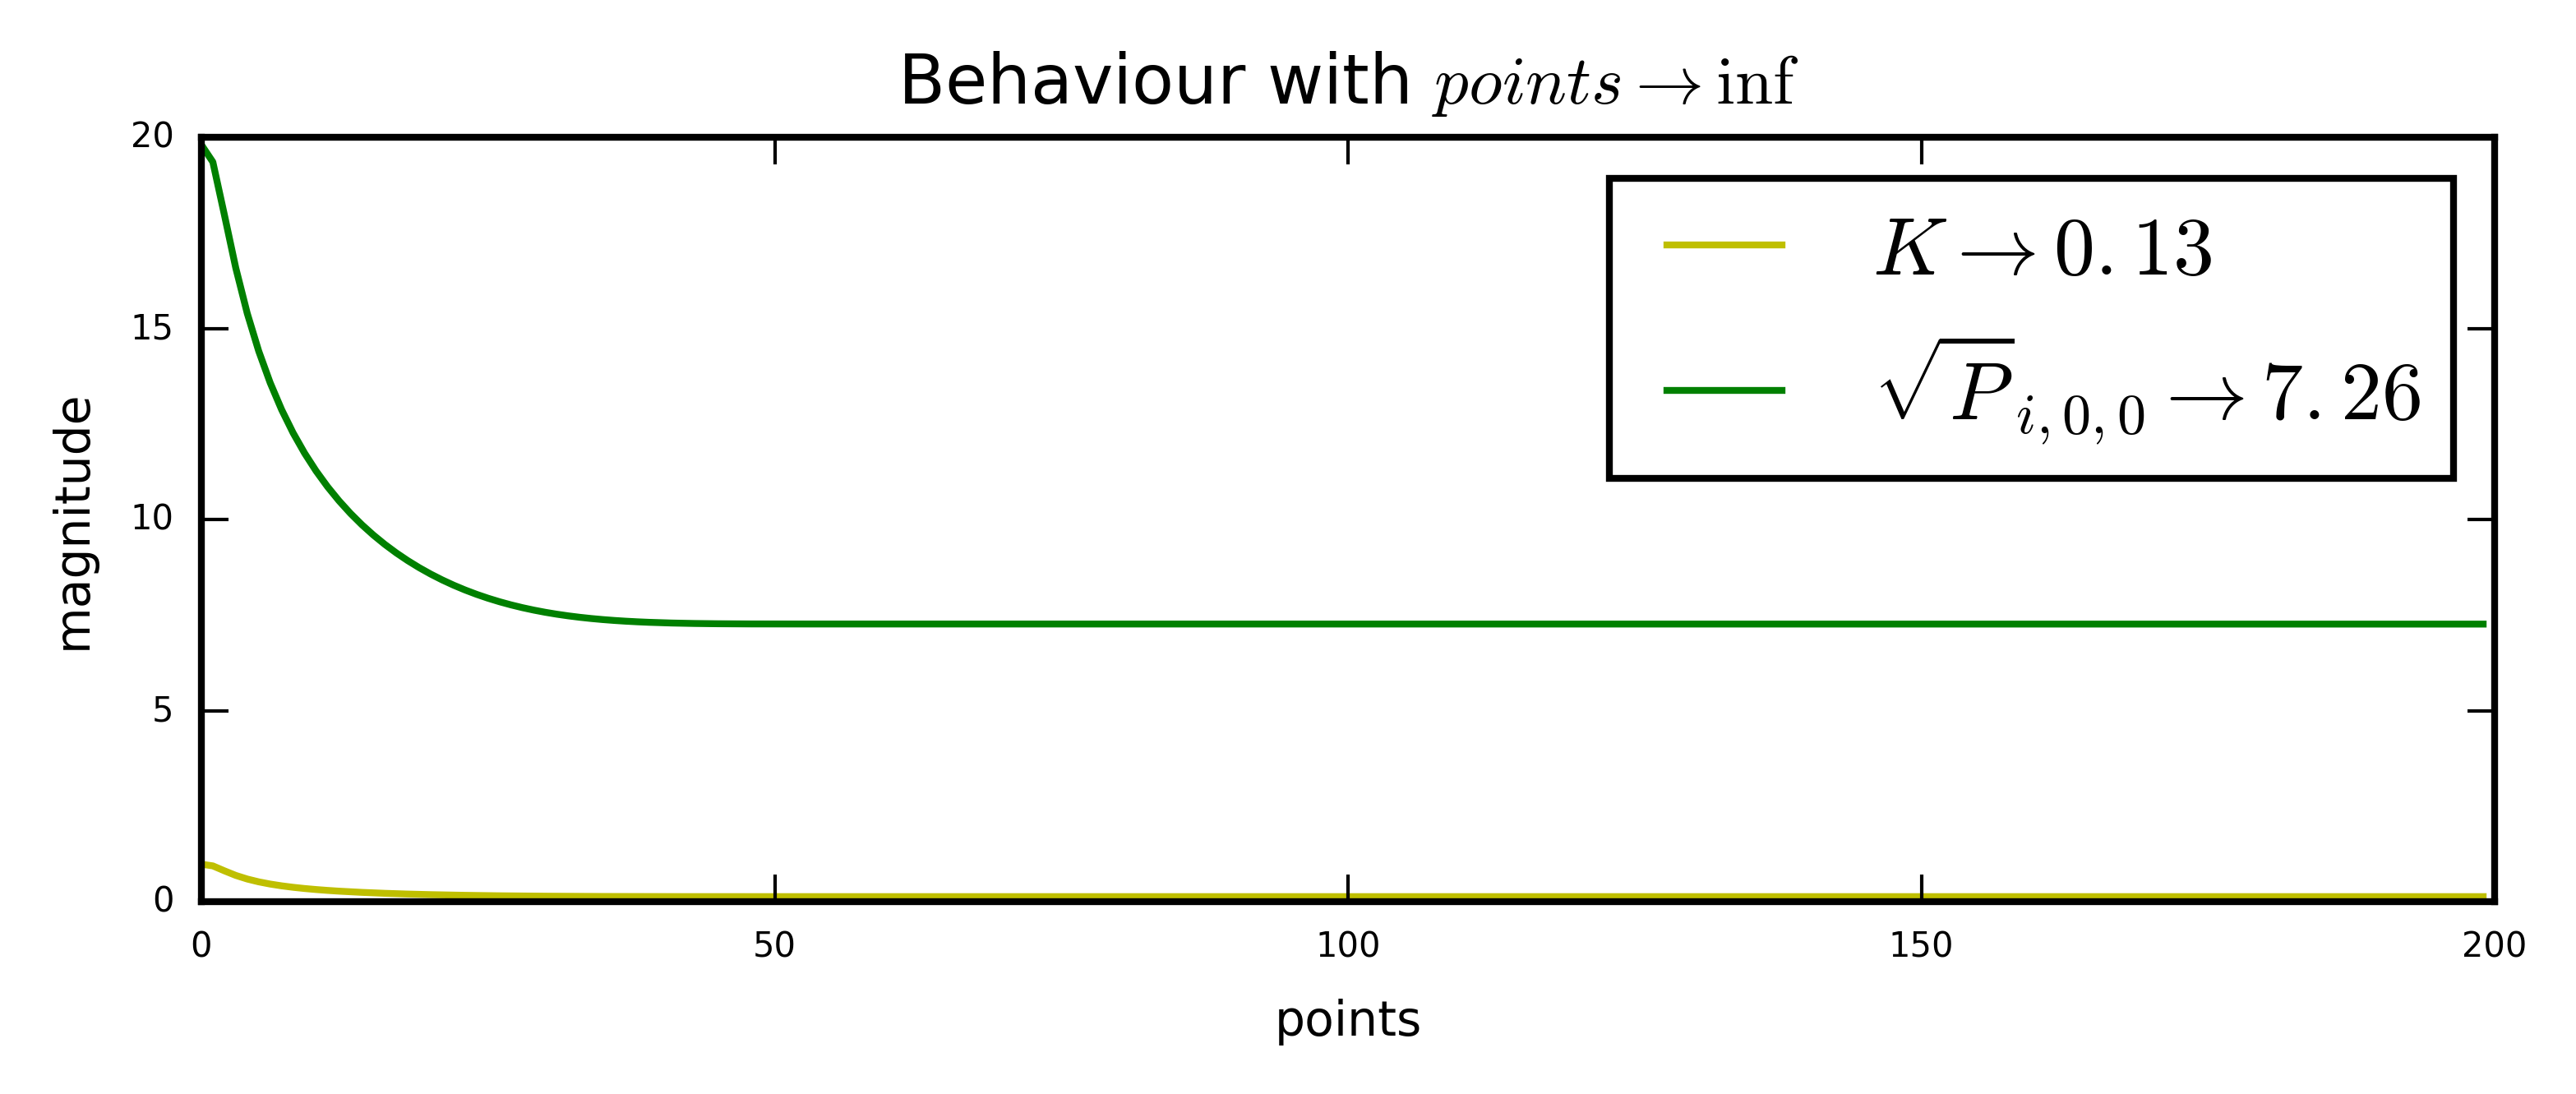

In [10]:
fig, ax = plt.subplots(1,2, figsize=(6,2), dpi = 600)
ax[0].set_title(r'$K \rightarrow %.2f$'%(np.average(K[100:N,0])), fontsize = 10)
ax[0].plot(range(N),K[:,0].transpose()[0],'y', linewidth = 1 )
#ax.plot(range(N),np.average(K[100:N,0])*np.ones(N), 'b--', label = '$K_{stable} = %.2f$'%(np.average(K[100:N,0])) )
ax[1].set_title(r'$\sqrt{P}_{i,0,0} \rightarrow %.2f$' % (np.average(P[100:N,0,0]**0.5)), fontsize = 10)
ax[1].plot(range(N),P[:,0,0]**0.5,'g')
ax[0].set_xlabel('points', fontsize = 7)
ax[1].set_xlabel('points', fontsize = 7)
ax[0].set_ylabel('magnitude', fontsize = 7);

In [11]:
np.average(K[100:N,0])

0.13185101644394534

# Here XF represents forecast for X

# And averaging the error

In [12]:
P_0 = np.matrix([[10000, 0], [0,10000]])
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXFore = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorXFore[:,i] = (x-XF[:,0,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


# Plot the difference for forecast and estimation

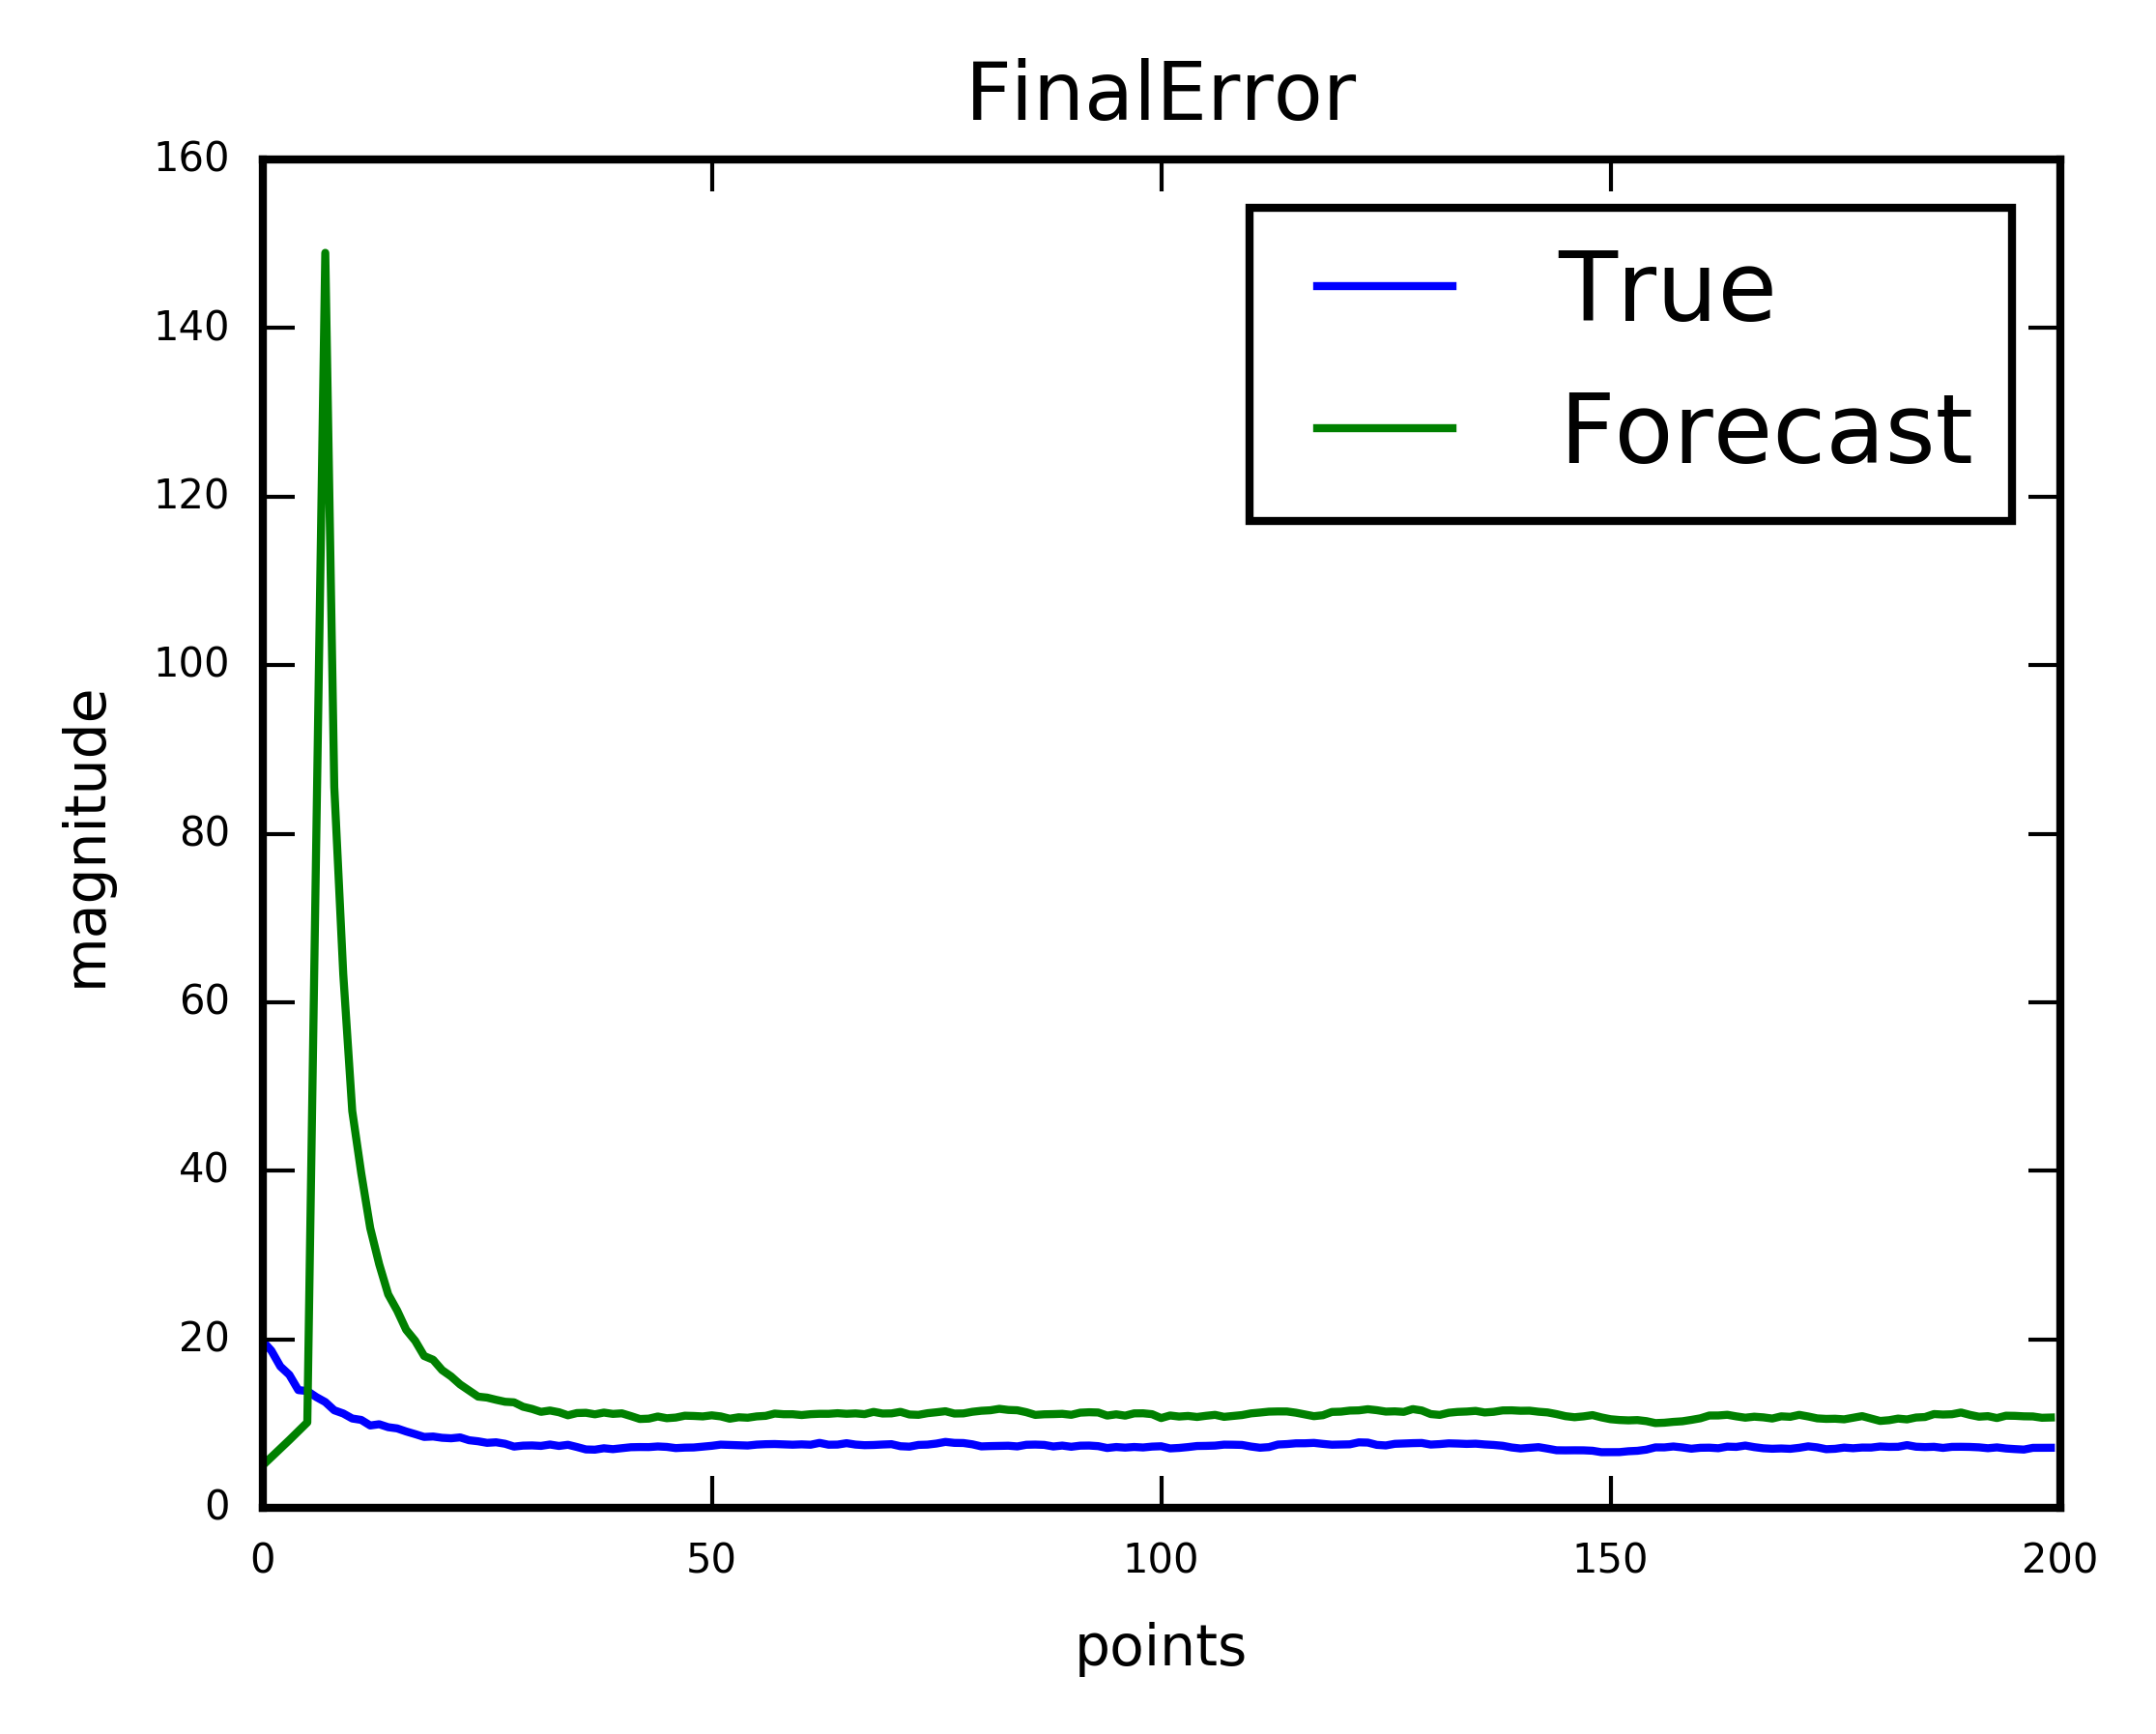

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi = 600)
ax.set_title('FinalError', fontsize = 10)
plt.plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'True')
plt.plot( (np.sum(ErrorXFore,axis=1)/(Repeats-1))**0.5,  label = 'Forecast')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

# Comparsion mean-squared error and standard deviation 

In [14]:
np.average(((np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5)[50:N] )

7.3020108729981725

$\sqrt{P_{0,0}} \rightarrow 7, \sigma_n = 20 \Rightarrow effective$  

# Run again with different $P_0$

In [15]:
P_0 = np.matrix([[100, 0], [0,100]])
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXFore = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorXFore[:,i] = (x-XF[:,0,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


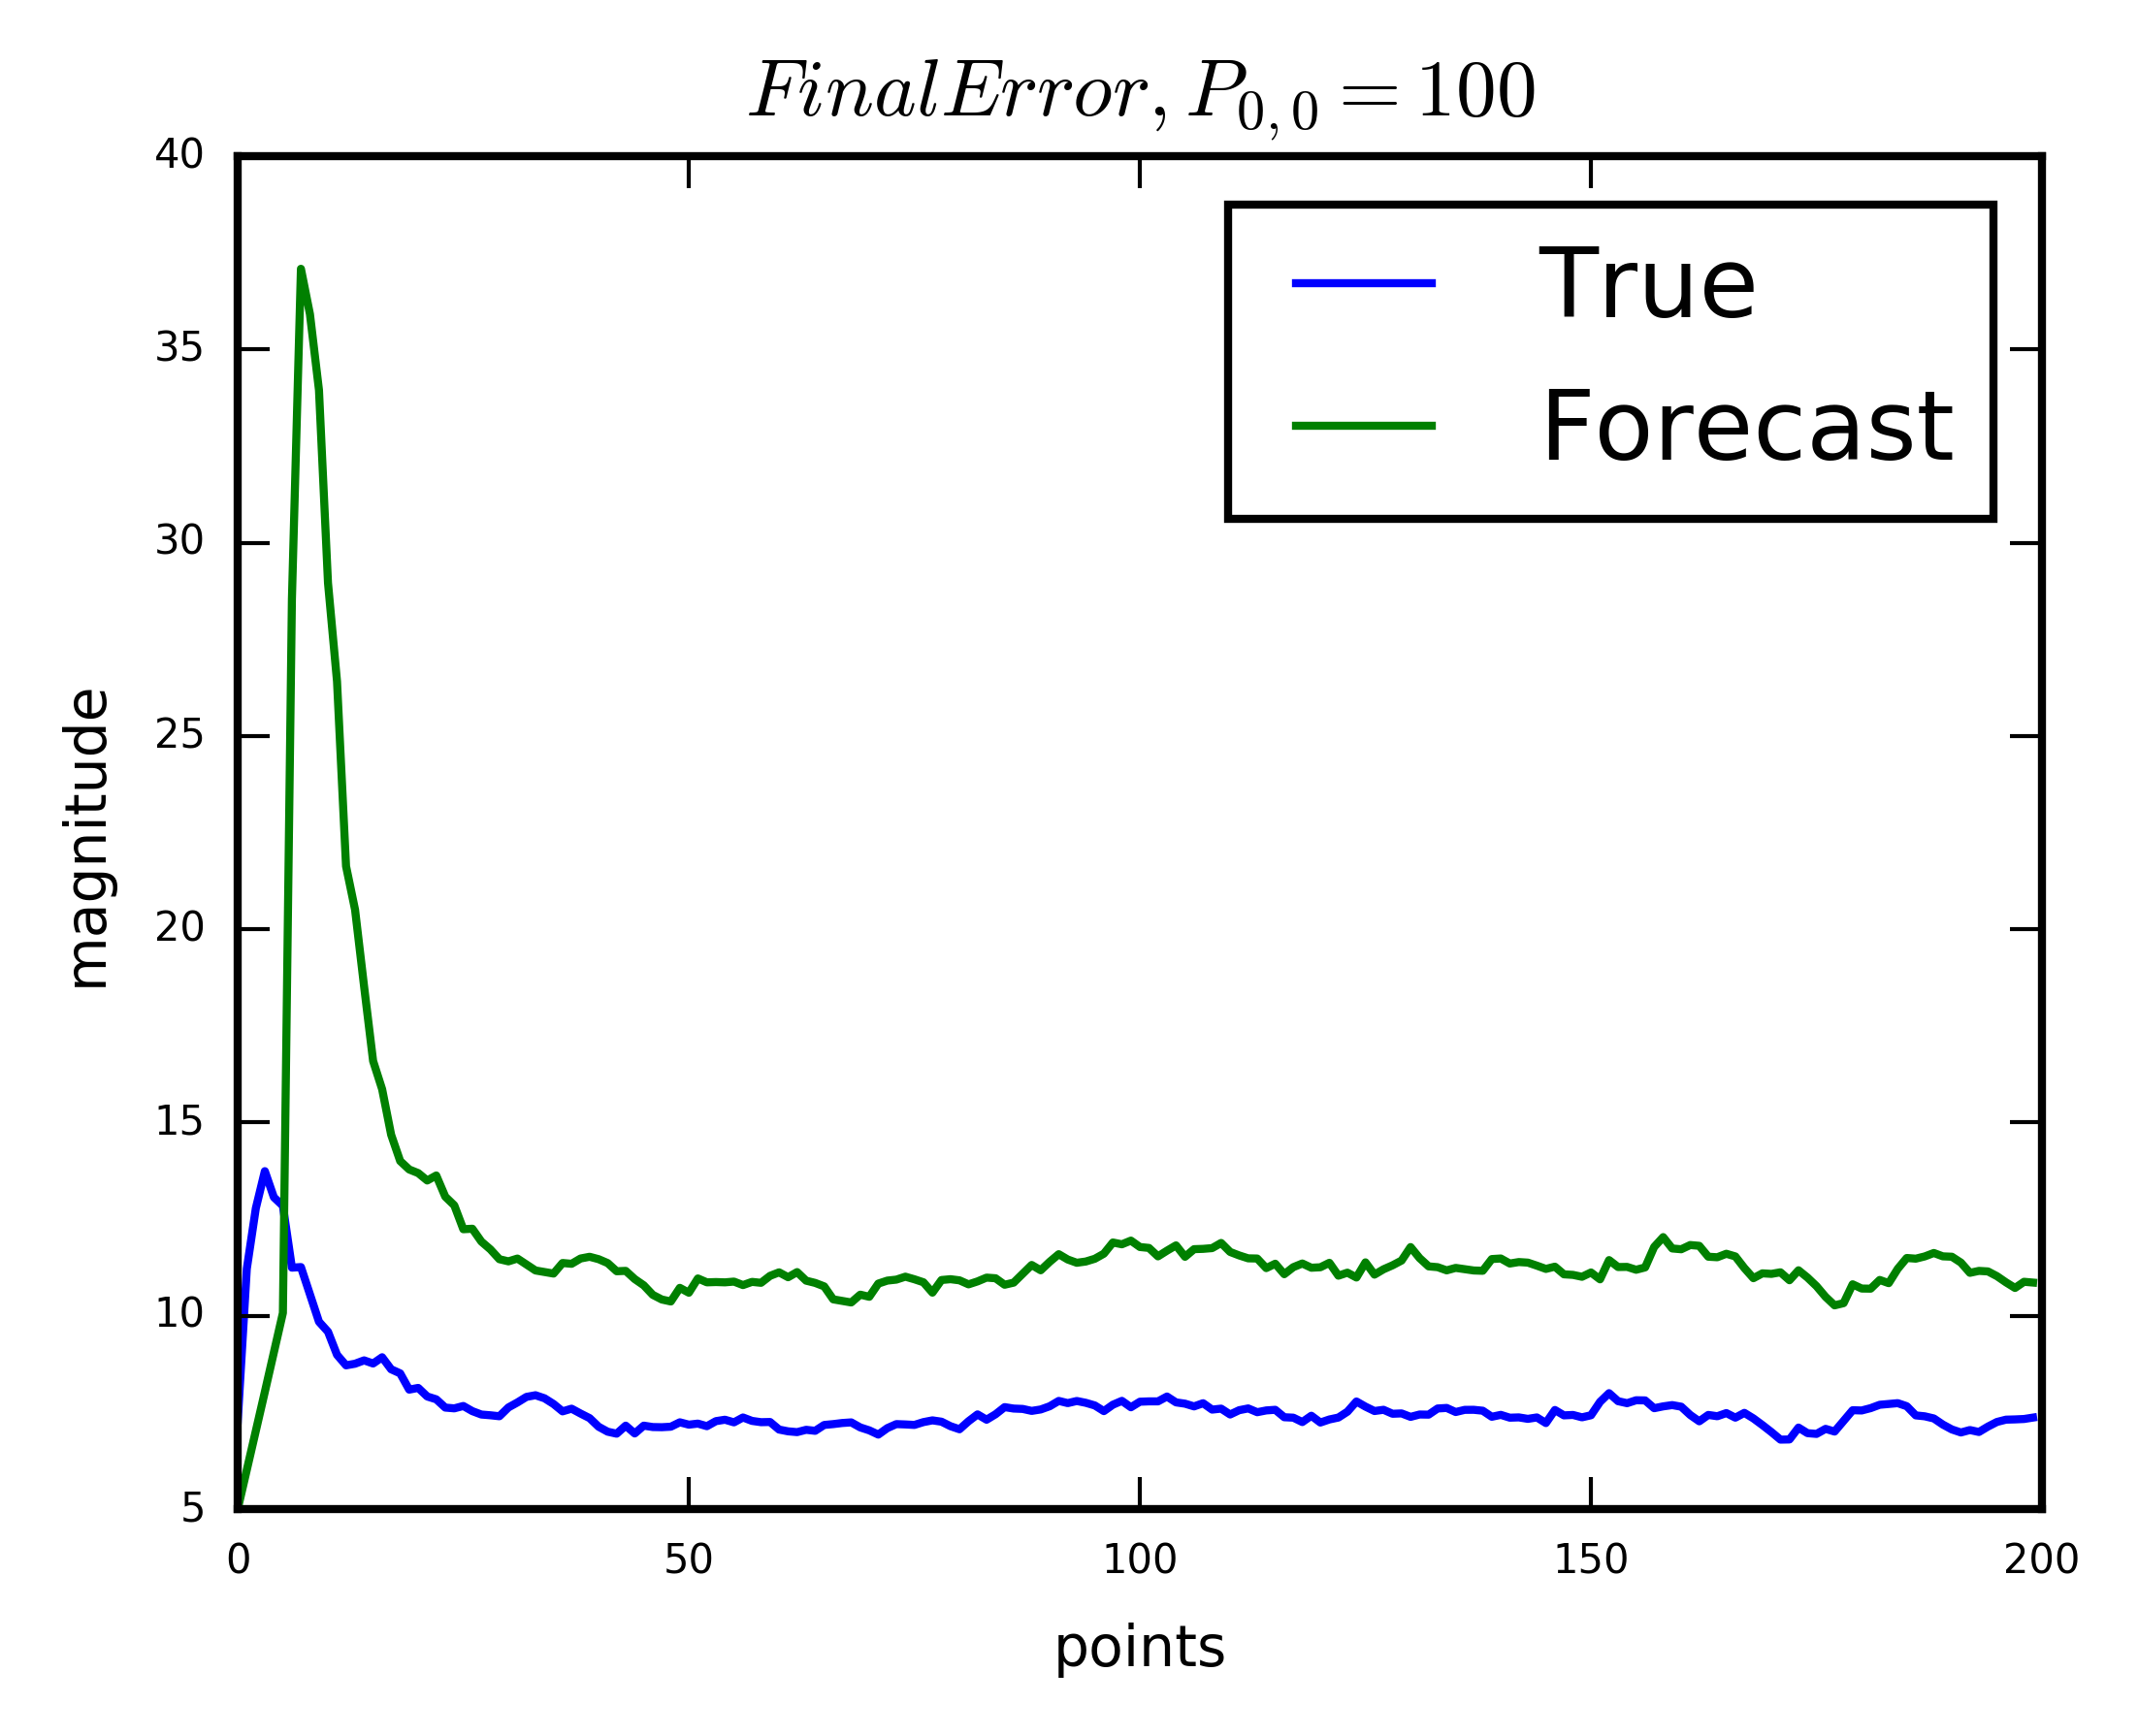

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi = 600)
ax.set_title('$FinalError, P_{0,0} = 100$', fontsize = 10)
plt.plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'True')
plt.plot( (np.sum(ErrorXFore,axis=1)/(Repeats-1))**0.5,  label = 'Forecast')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

### Even scale of the plot tells us that we removed  huge errors at first time choosing better P. For big time there is no visible difference 

In [17]:
np.average(((np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5)[50:N] )

7.4104976005407073

# Correspondance between $\sqrt{P}_{0,0}$ and true estimation error...

In [37]:
P_0 = np.matrix([[10000, 0], [0,10000]])
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXFore = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorXFore[:,i] = (x-XF[:,0,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


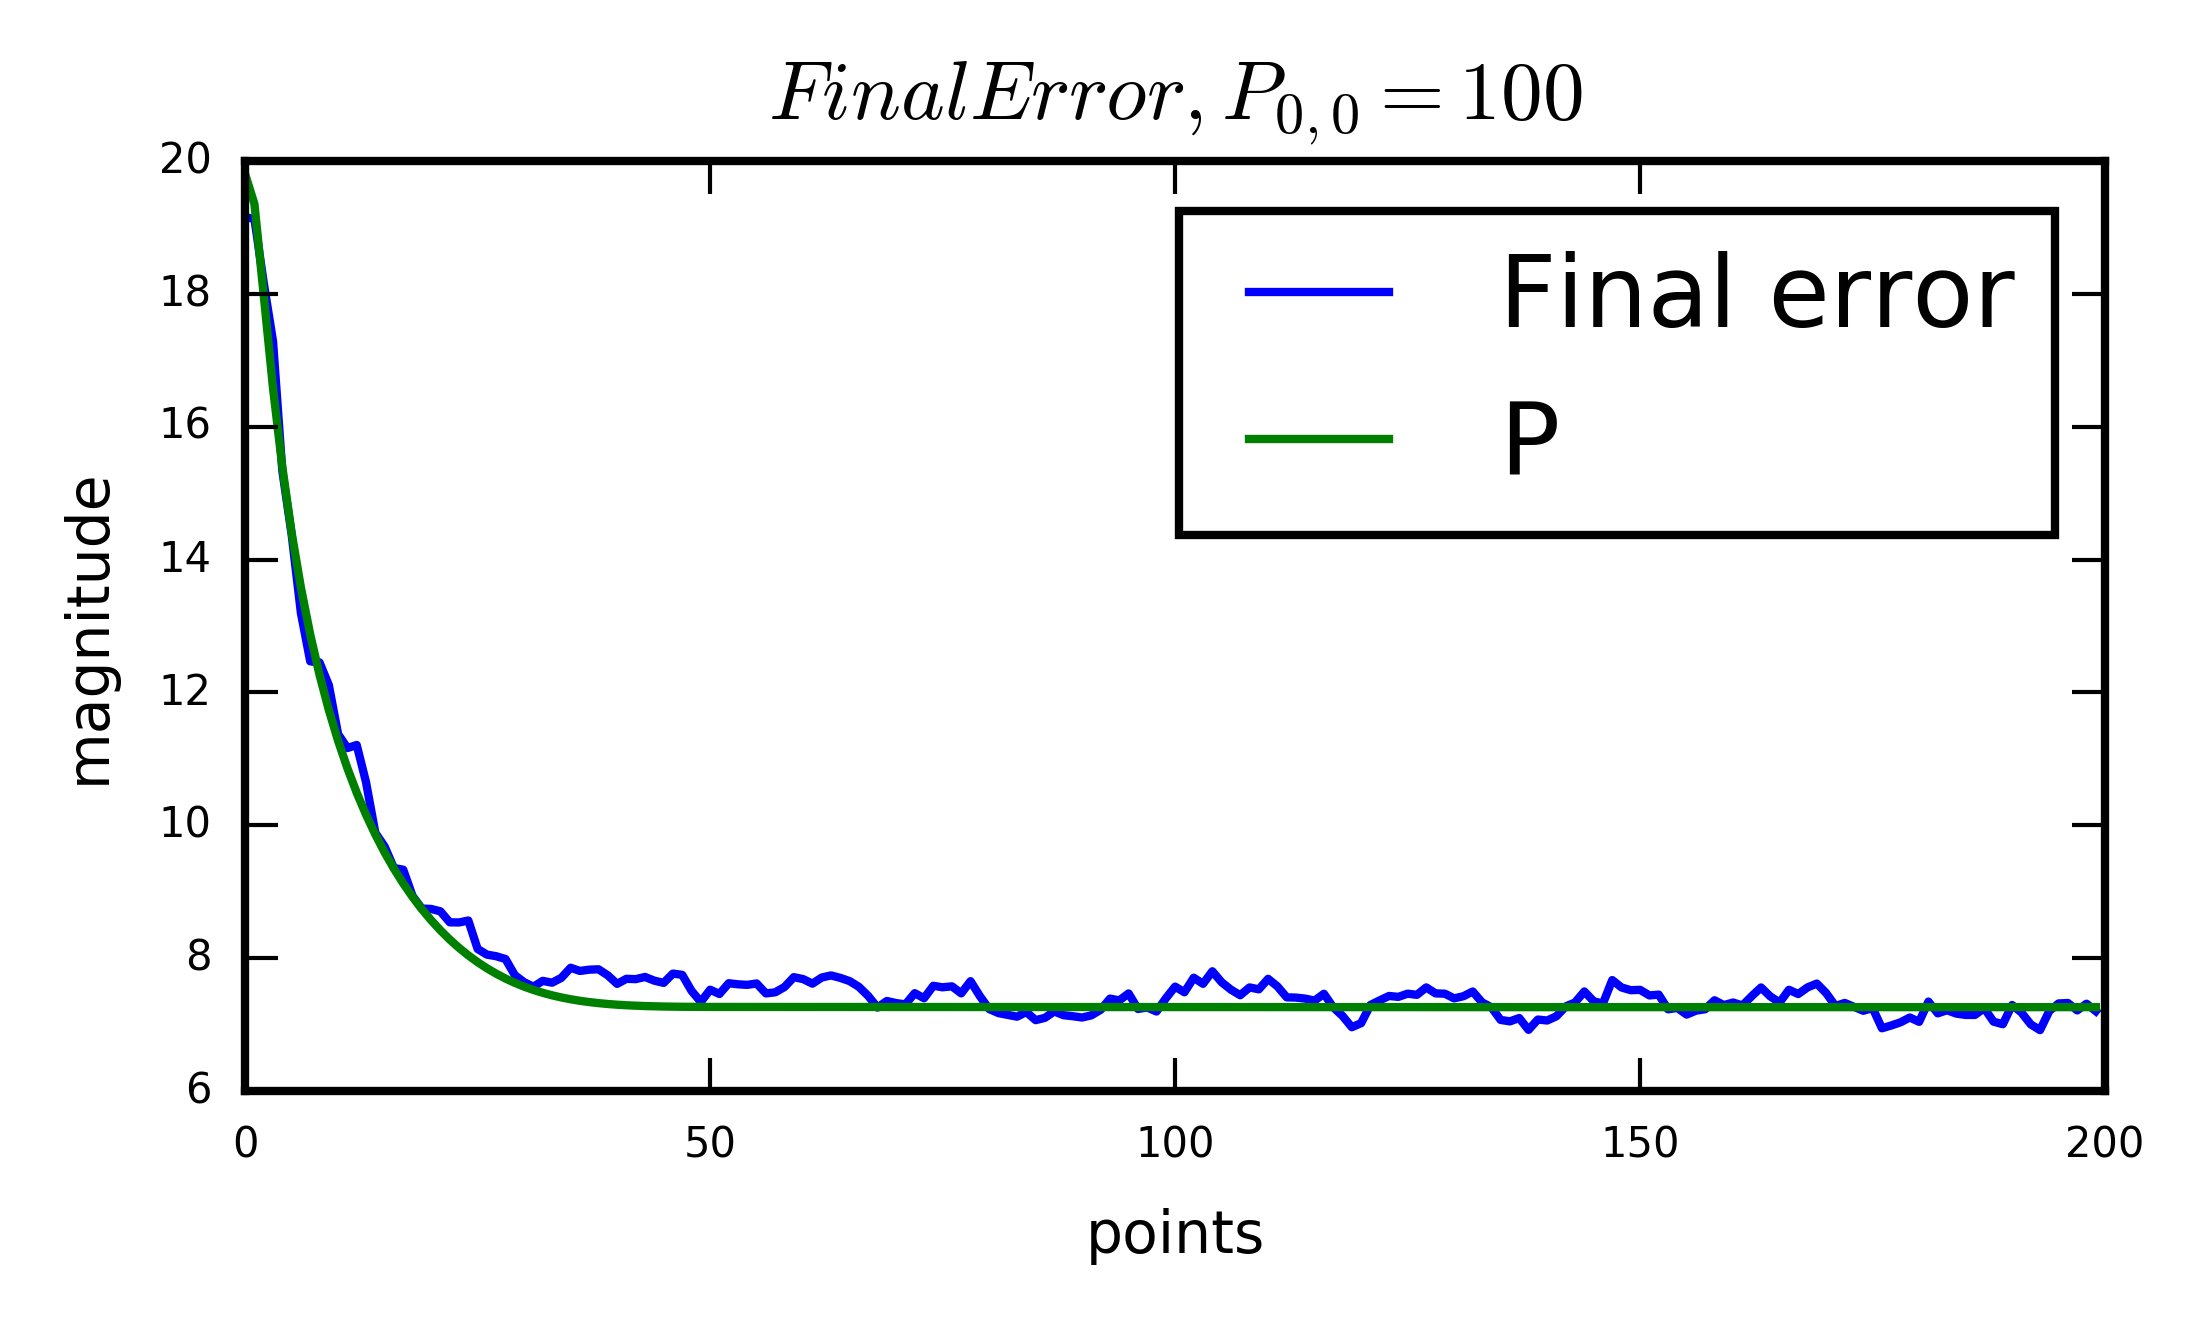

In [40]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi = 600)
ax.set_title('$FinalError, P_{0,0} = 100$', fontsize = 10)
ax.plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'Final error')
ax.plot(range(N),P[:,0,0]**0.5,'g',  label = 'P')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

## ...is easily visible

# Deterministic trajectory, $\sigma_a = 0$

In [92]:
N=1000
x, z = generate_acc_trajectory(0, sigma_n**2, N, x_1, v_1, t)
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q*0)

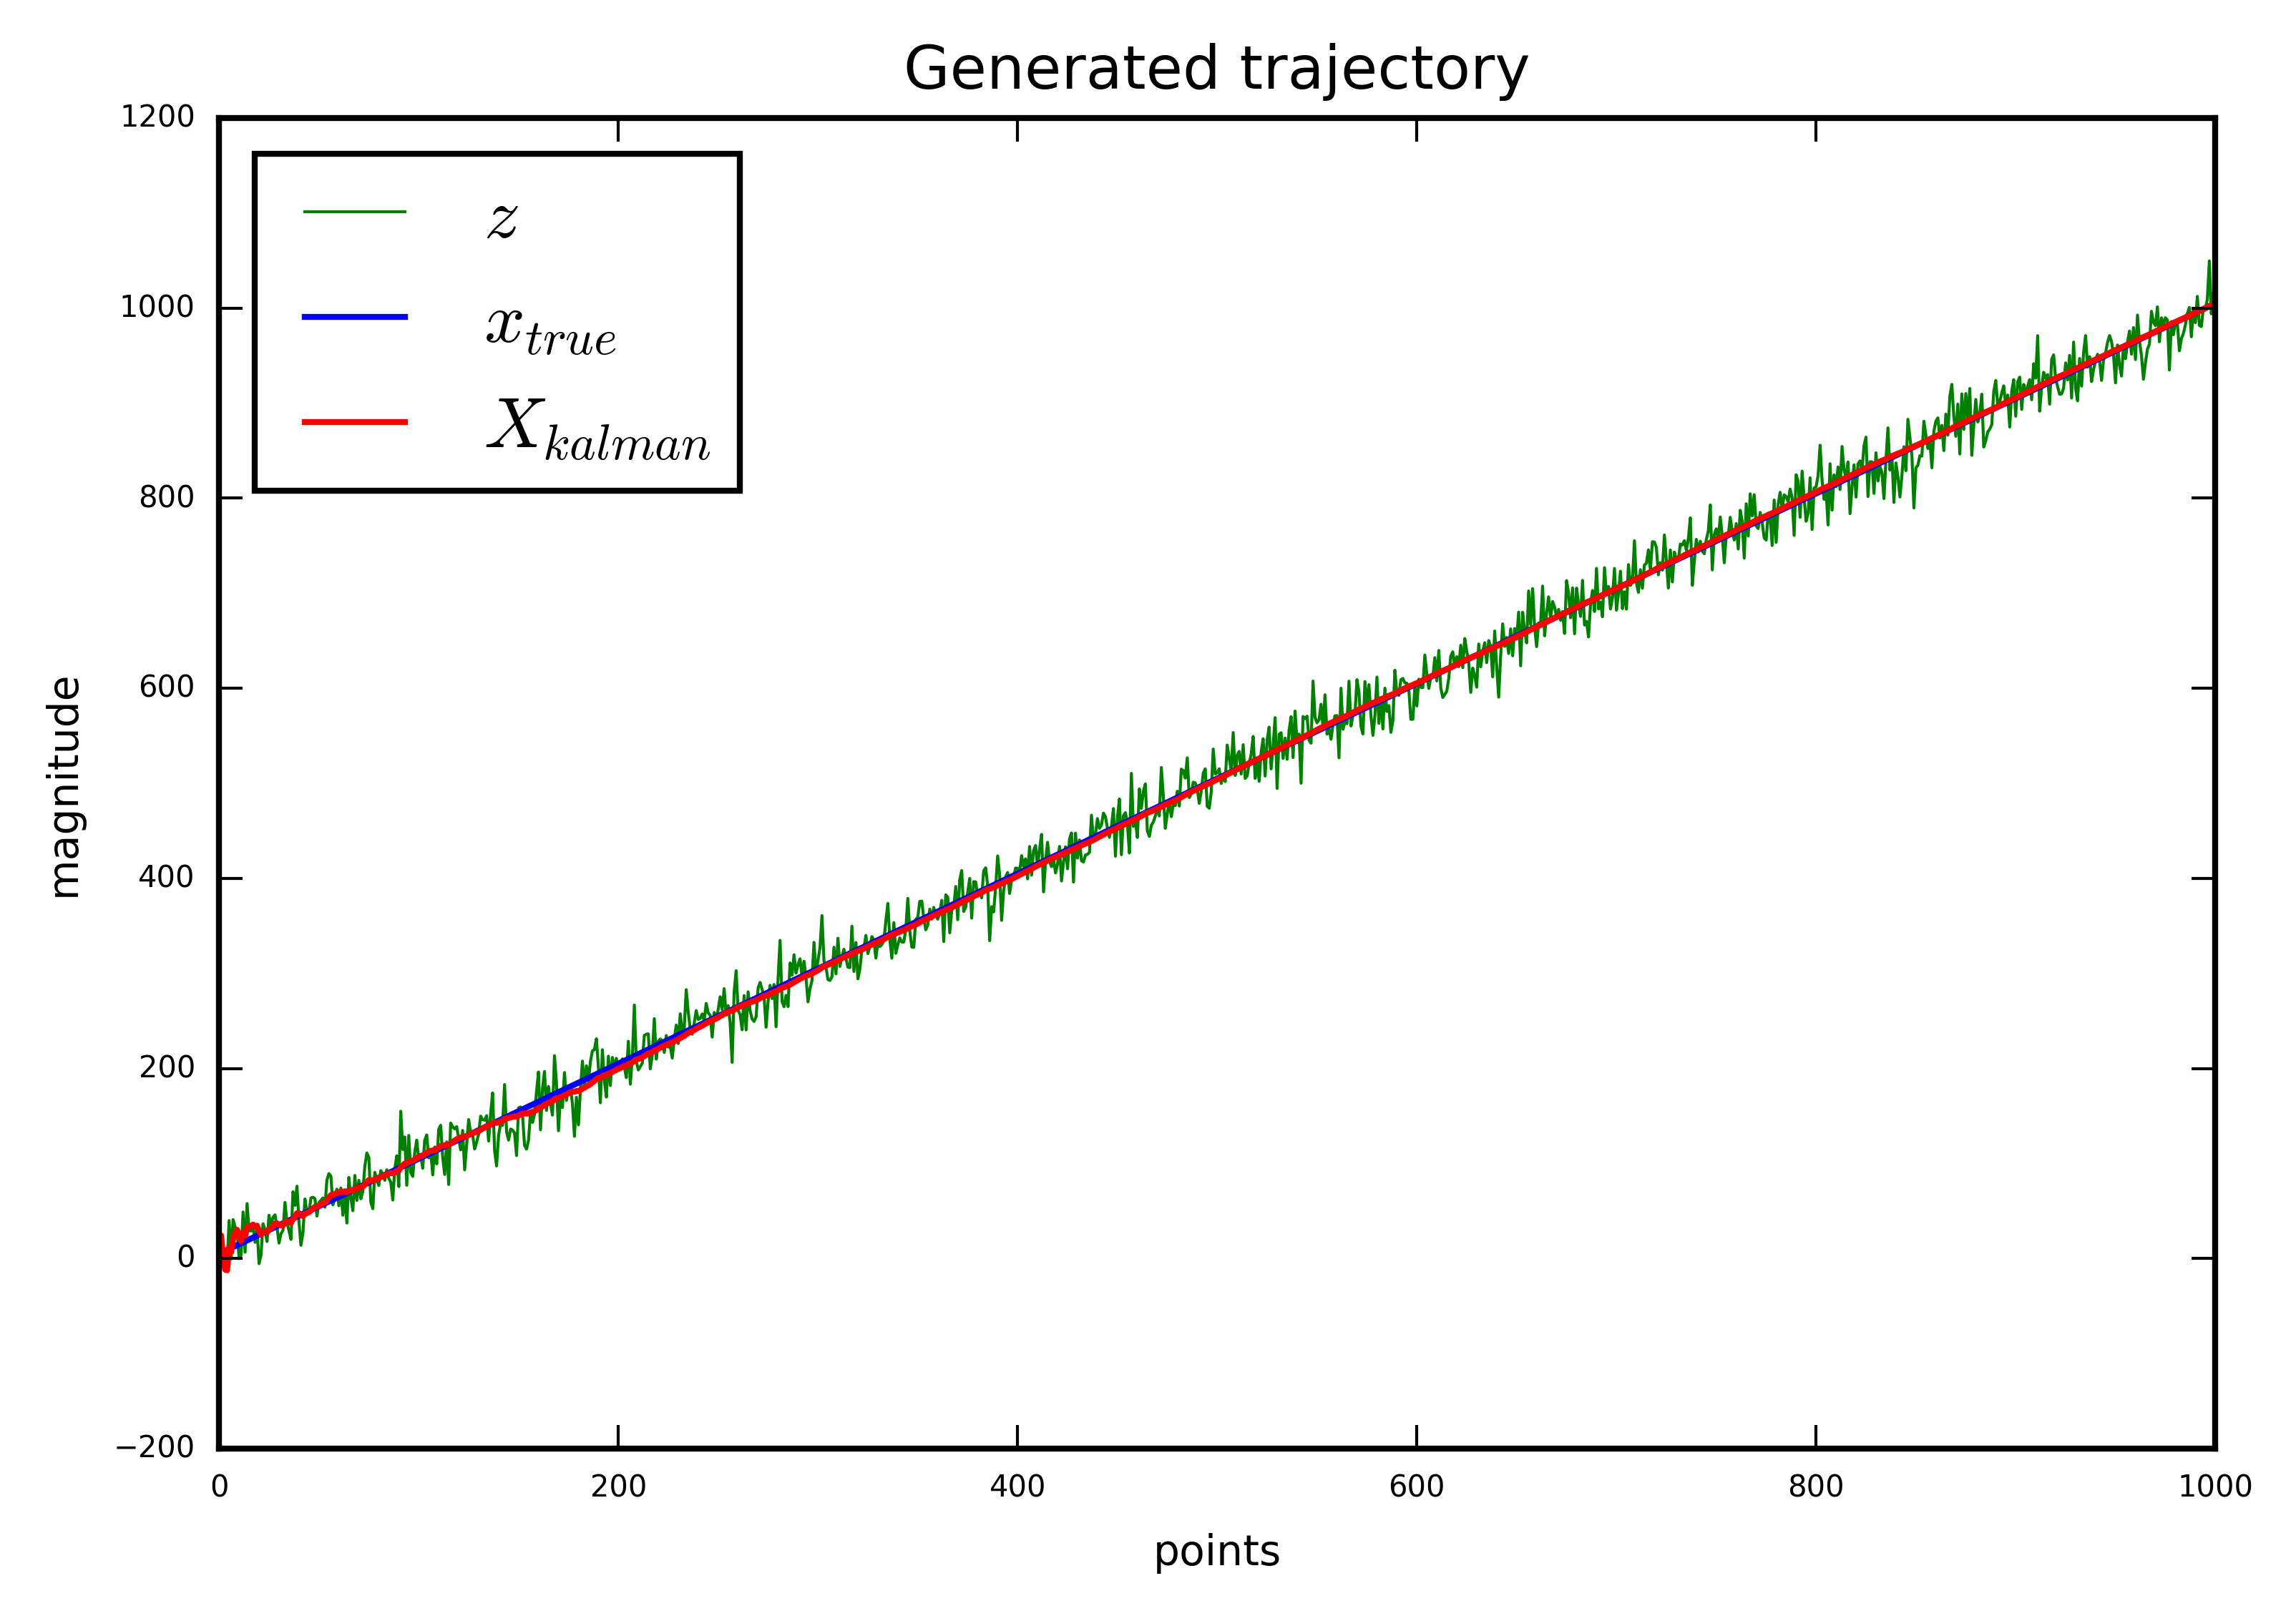

In [93]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax.plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.legend(loc='upper left')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

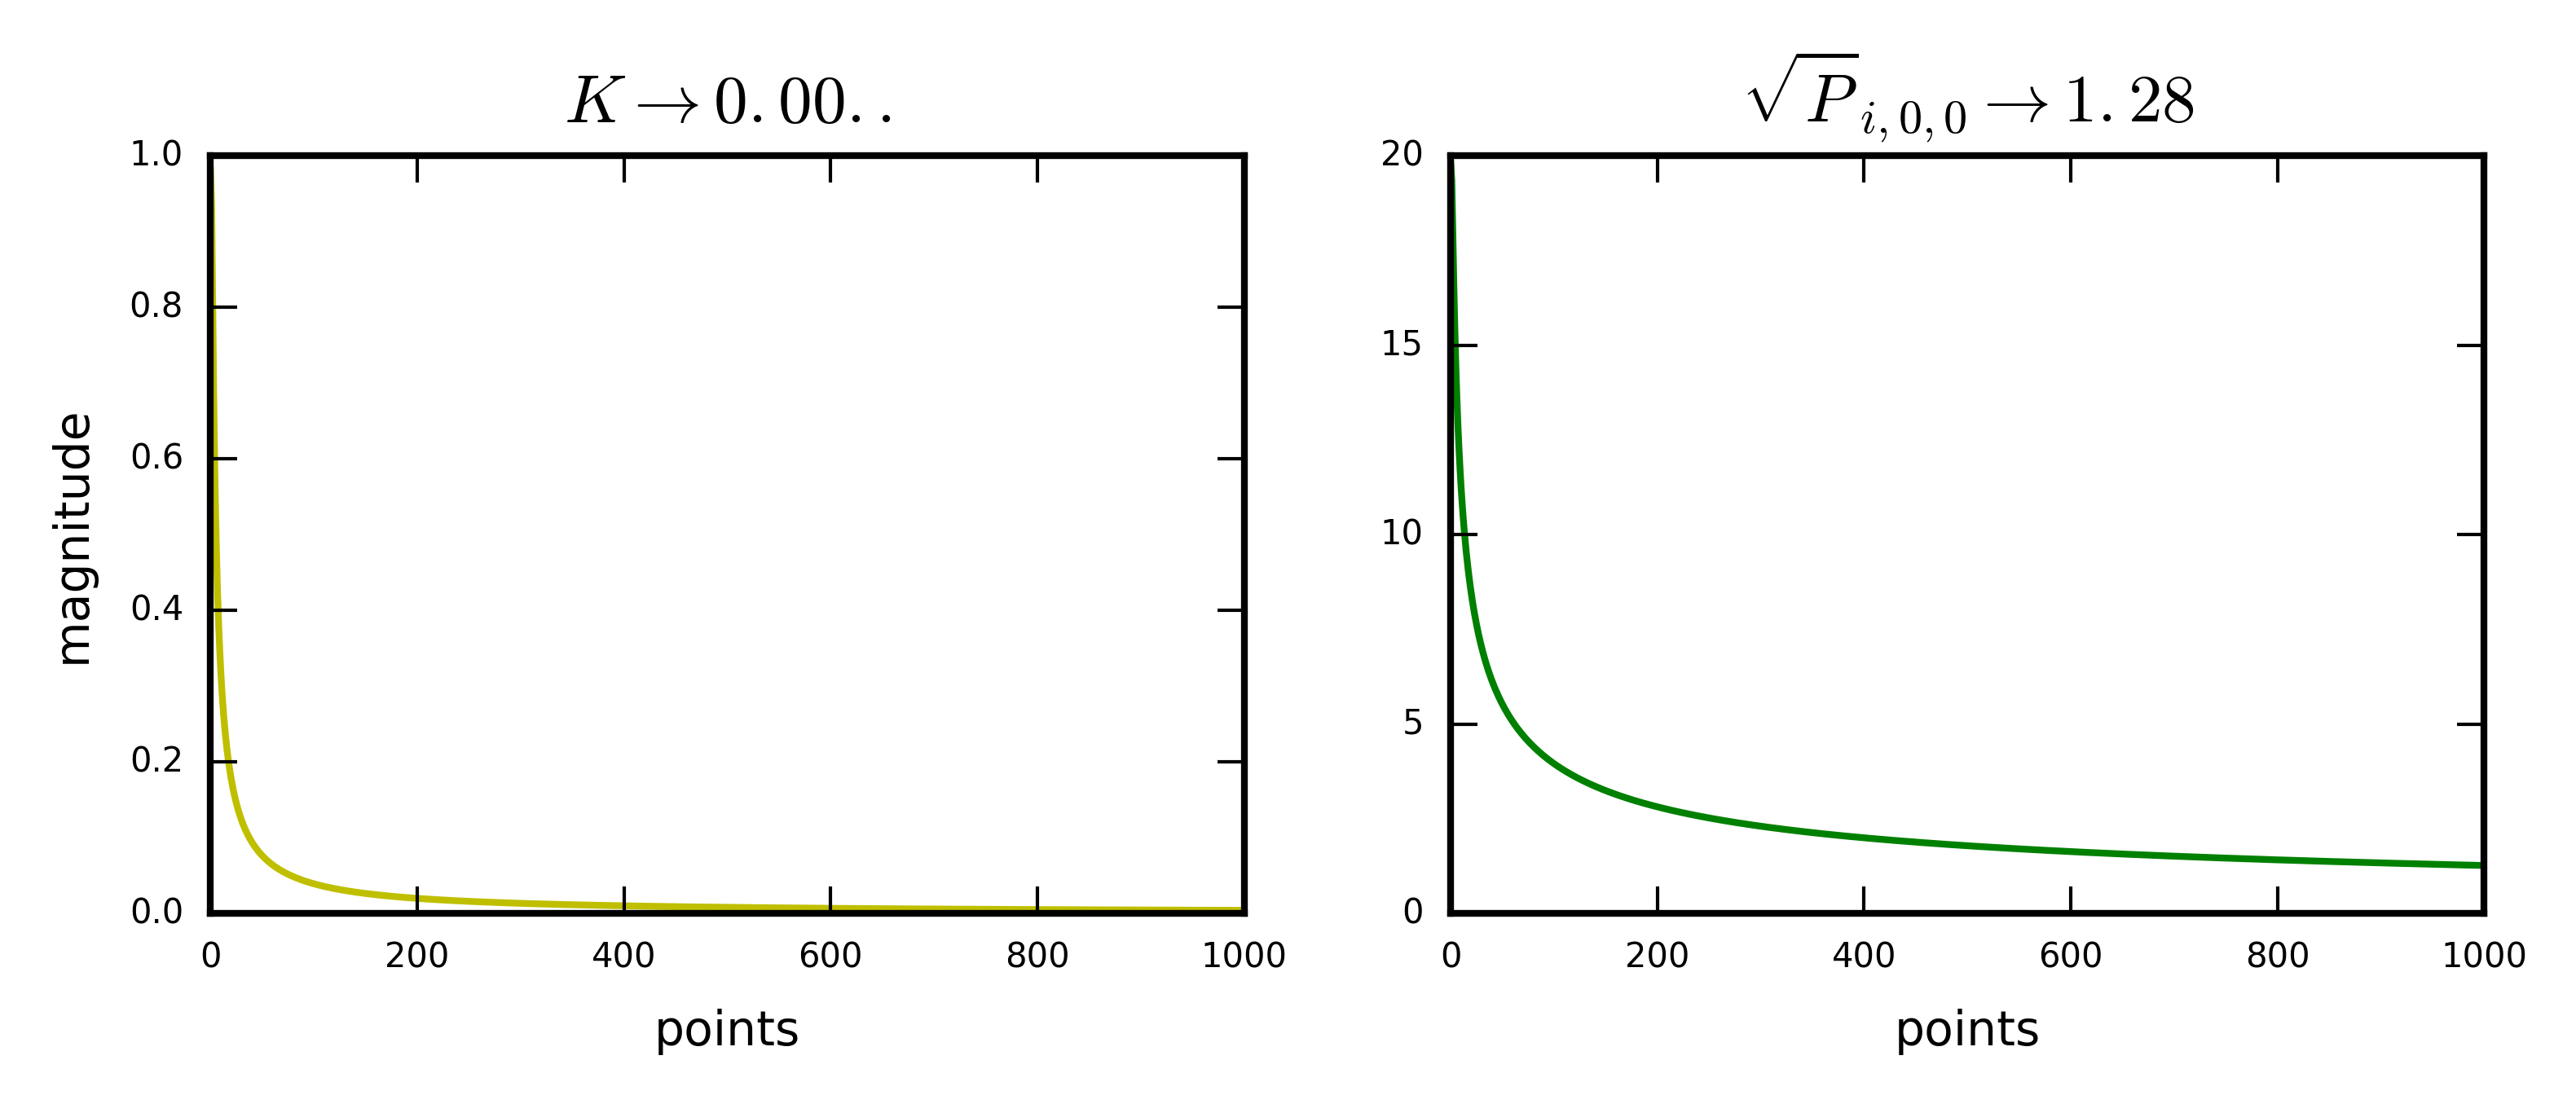

In [94]:
fig, ax = plt.subplots(1,2, figsize=(6,2), dpi = 600)
ax[0].set_title(r'$K \rightarrow %.2f..$'%(np.average(K[N-50:N,0])), fontsize = 10)
ax[0].plot(range(N),K[:,0].transpose()[0],'y', linewidth = 1 )
#ax.plot(range(N),np.average(K[100:N,0])*np.ones(N), 'b--', label = '$K_{stable} = %.2f$'%(np.average(K[100:N,0])) )
ax[1].set_title(r'$\sqrt{P}_{i,0,0} \rightarrow %.2f$' % (np.average(P[N-50:N,0,0]**0.5)), fontsize = 10)
ax[1].plot(range(N),P[:,0,0]**0.5,'g')
ax[0].set_xlabel('points', fontsize = 7)
ax[1].set_xlabel('points', fontsize = 7)
ax[0].set_ylabel('magnitude', fontsize = 7);

In [102]:
N = 200
Repeats = 500
sigma_a = 0.2
Q = G.dot(G.transpose())*sigma_a**2
X_0 = np.array([[2],[0]])
ErrorXTrue = np.zeros((N,Repeats))
PX = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(0, sigma_n**2, N, x_1, v_1, t)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q*0)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    PX[:,i] = P[:,0,0]**0.5
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


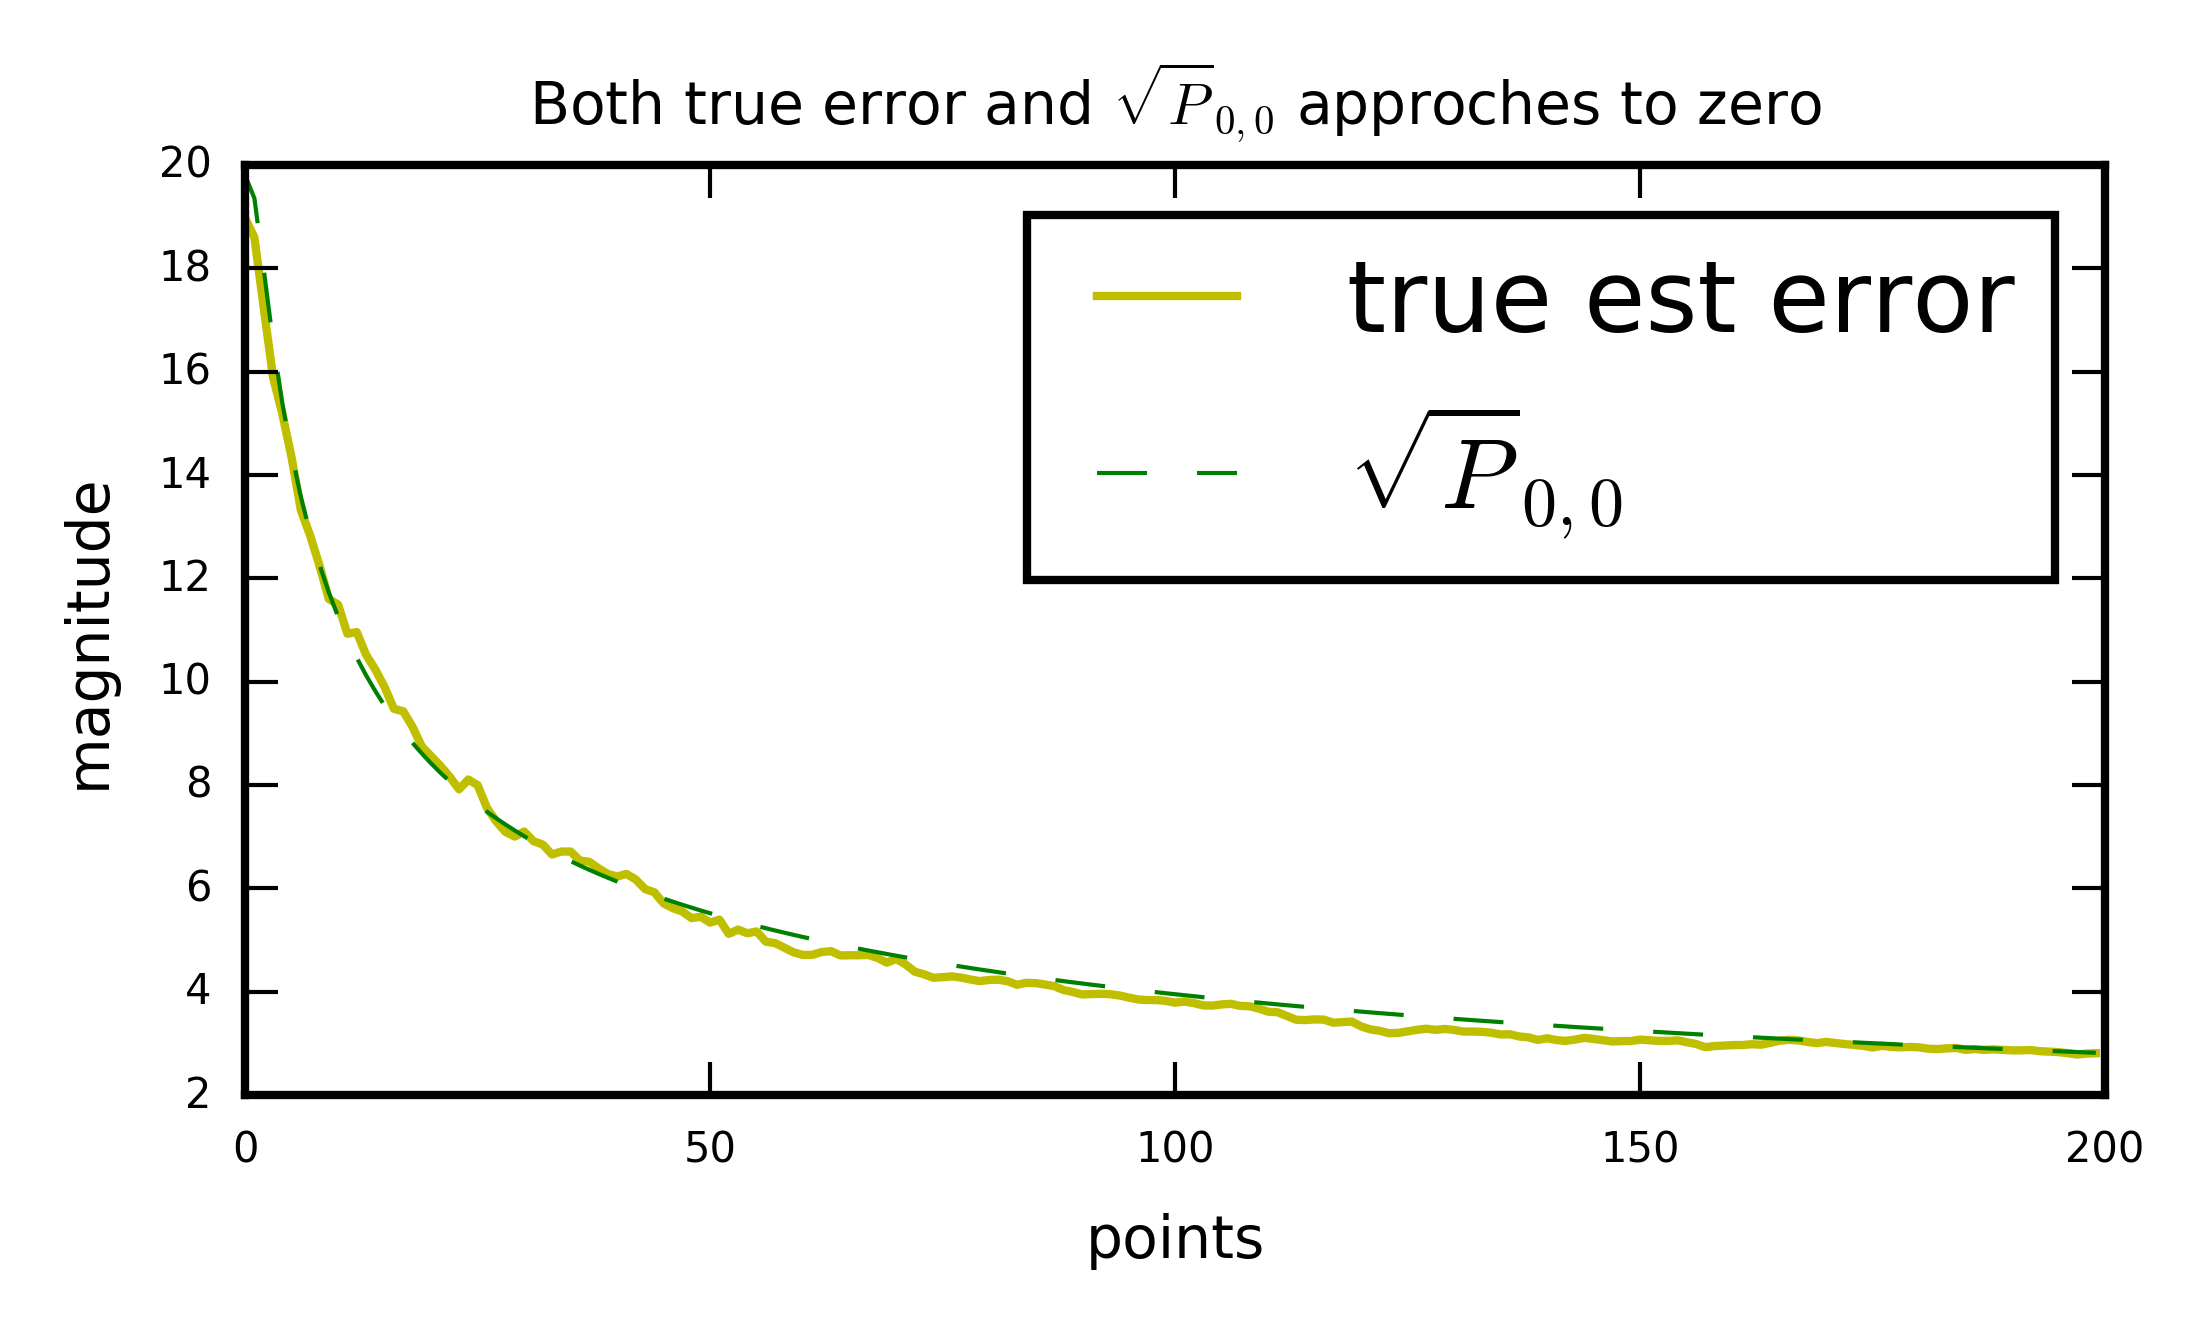

In [106]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi = 600)
ax.set_title(r'Both true error and $\sqrt{P}_{0,0}$ approches to zero', fontsize=7)
#ax[0].set_title(r'$K \rightarrow %.2f..$'%(np.average(K[N-50:N,0])), fontsize = 10)
ax.plot(range(N),(np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5,'y',label = 'true est error', linewidth = 1 )
#ax.plot(range(N),np.average(K[100:N,0])*np.ones(N), 'b--', label = '$K_{stable} = %.2f$'%(np.average(K[100:N,0])) )
#ax[1].set_title(r'$\sqrt{P}_{i,0,0} \rightarrow %.2f$' % (np.average(P[N-50:N,0,0]**0.5)), fontsize = 10)
ax.plot(range(N),np.sum(PX,axis=1)/(Repeats),'g--', label = r'$\sqrt{P}_{0,0}$',linewidth = 0.5)
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

# Generate all trajectories with $\sigma_a = 0.2$, but use $Q = 0$ in Kalman filter

In [113]:
N=500
x, z = generate_acc_trajectory(sigma_a, sigma_n**2, N, x_1, v_1, t)
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q*0)

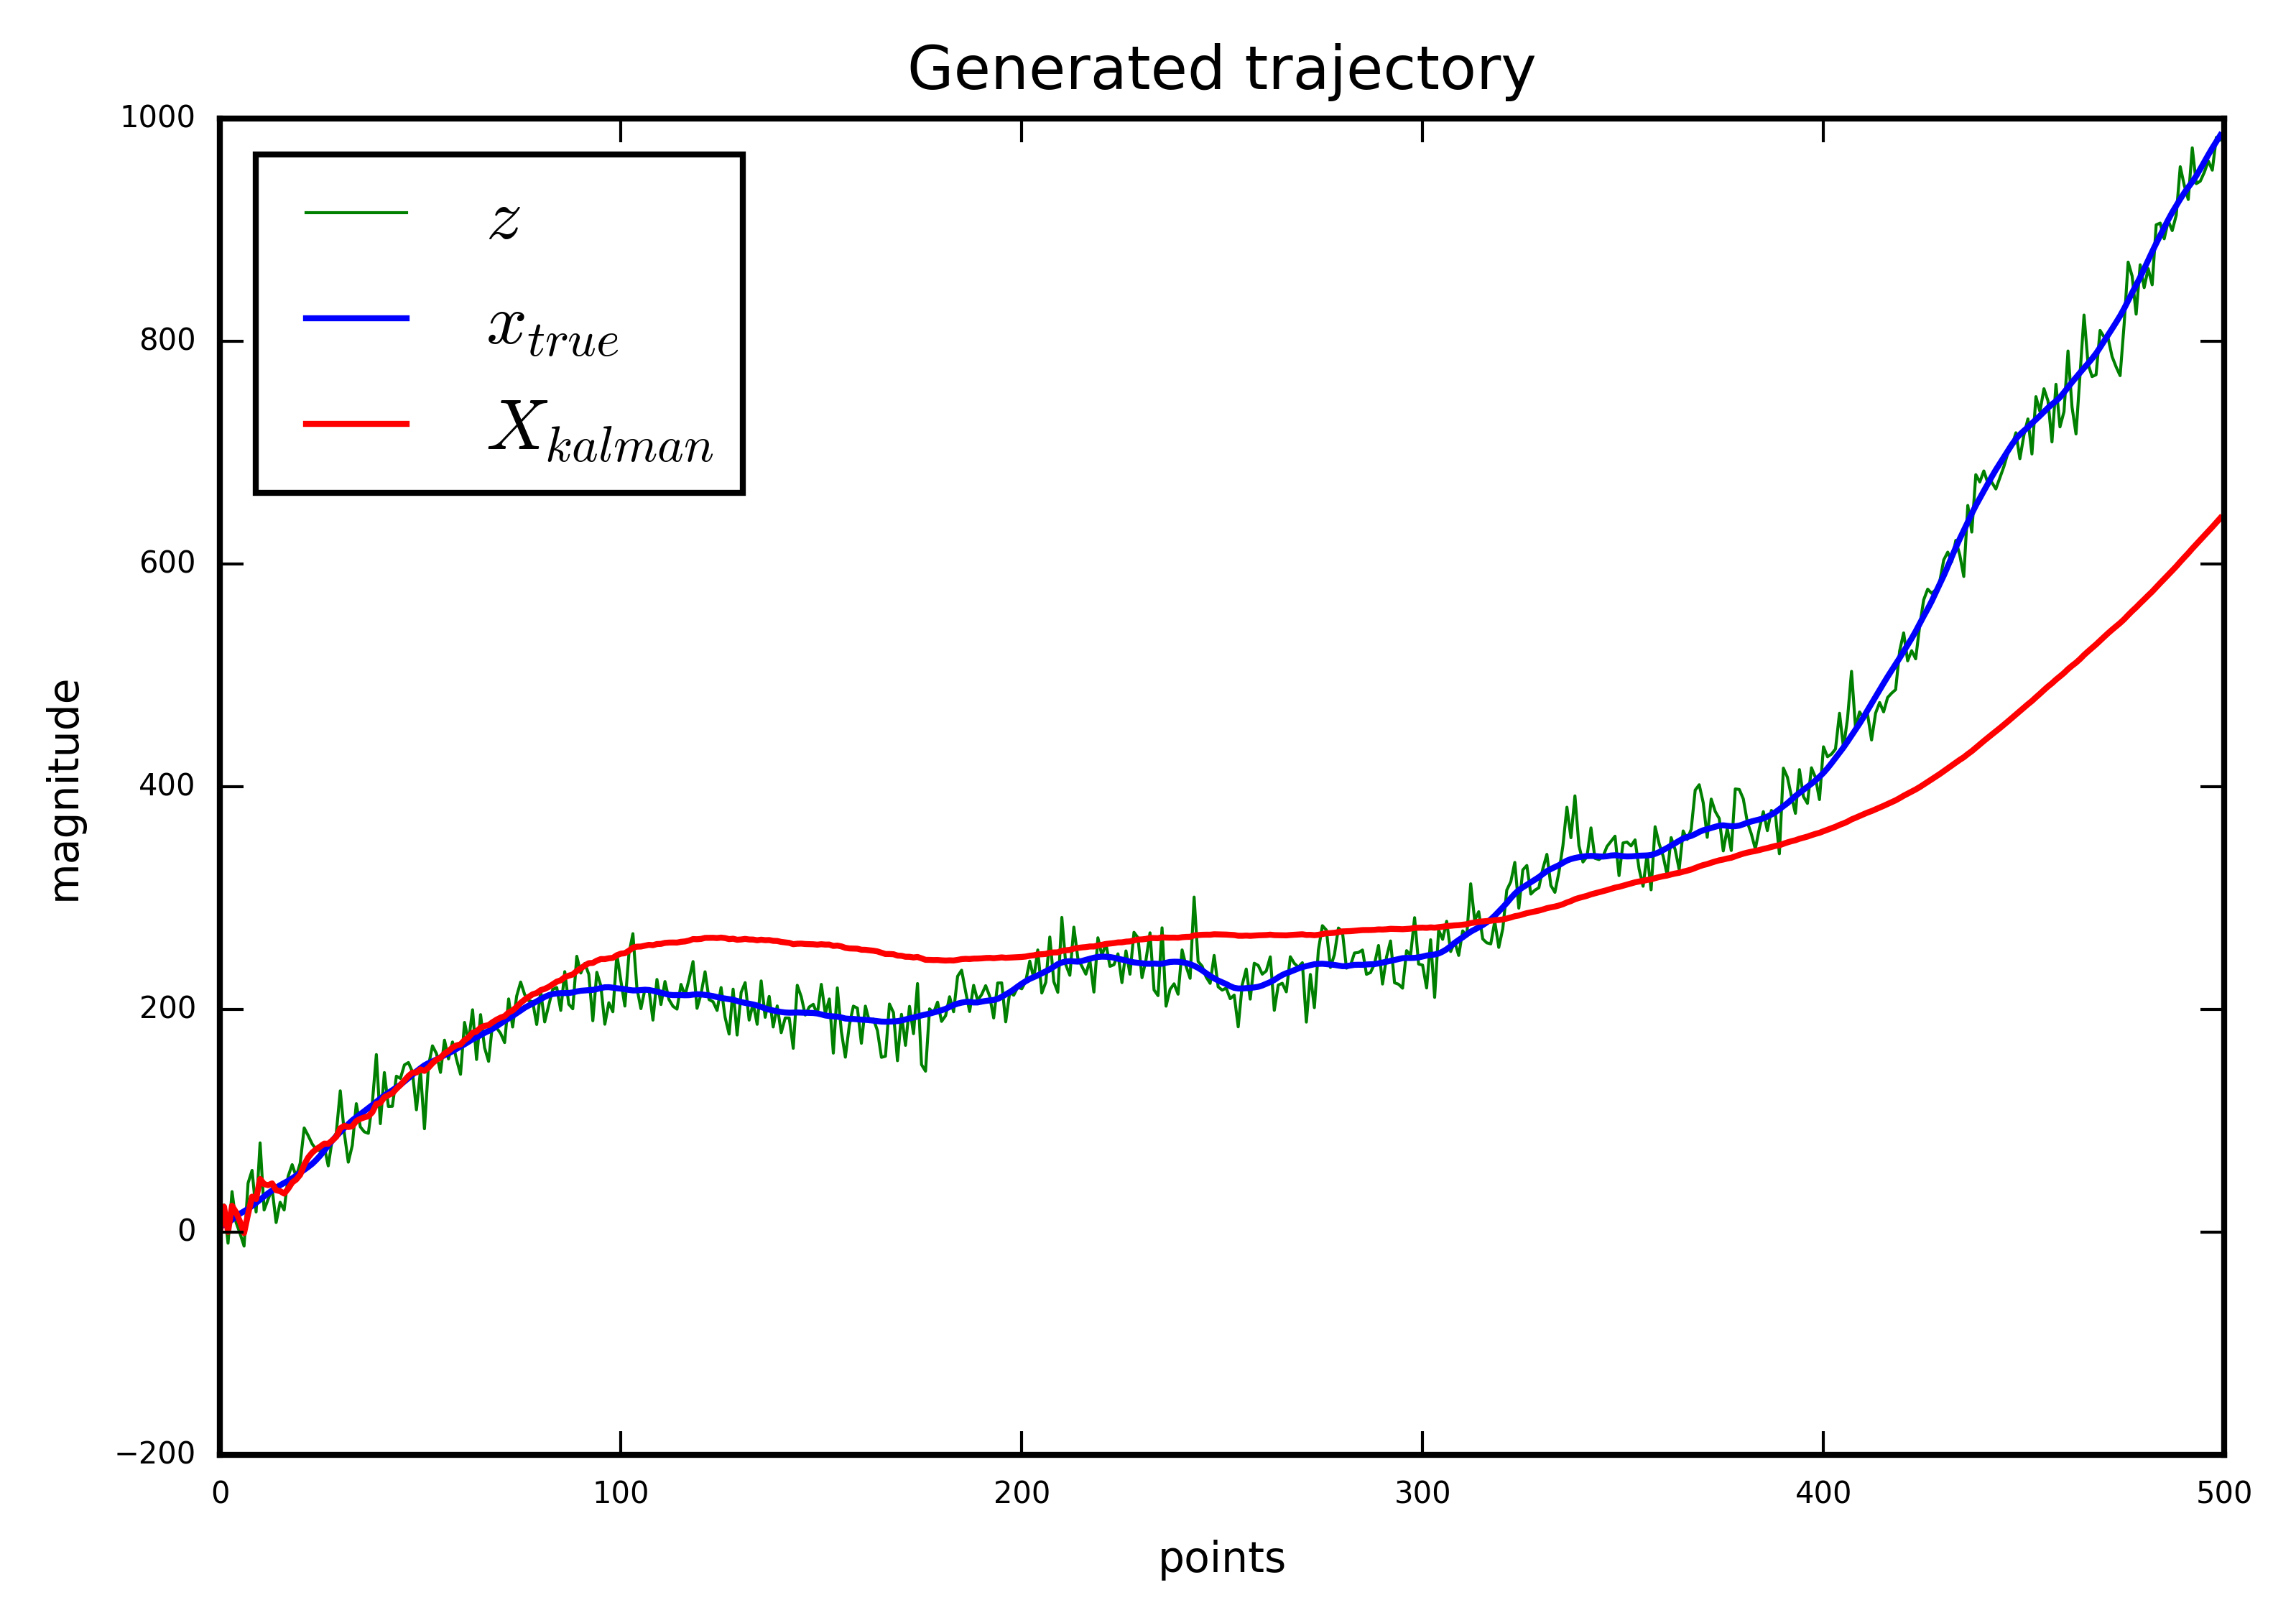

In [114]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax.plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.legend(loc='upper left')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

In [101]:
N = 200
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXFore = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q*0)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorXFore[:,i] = (x-XF[:,0,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


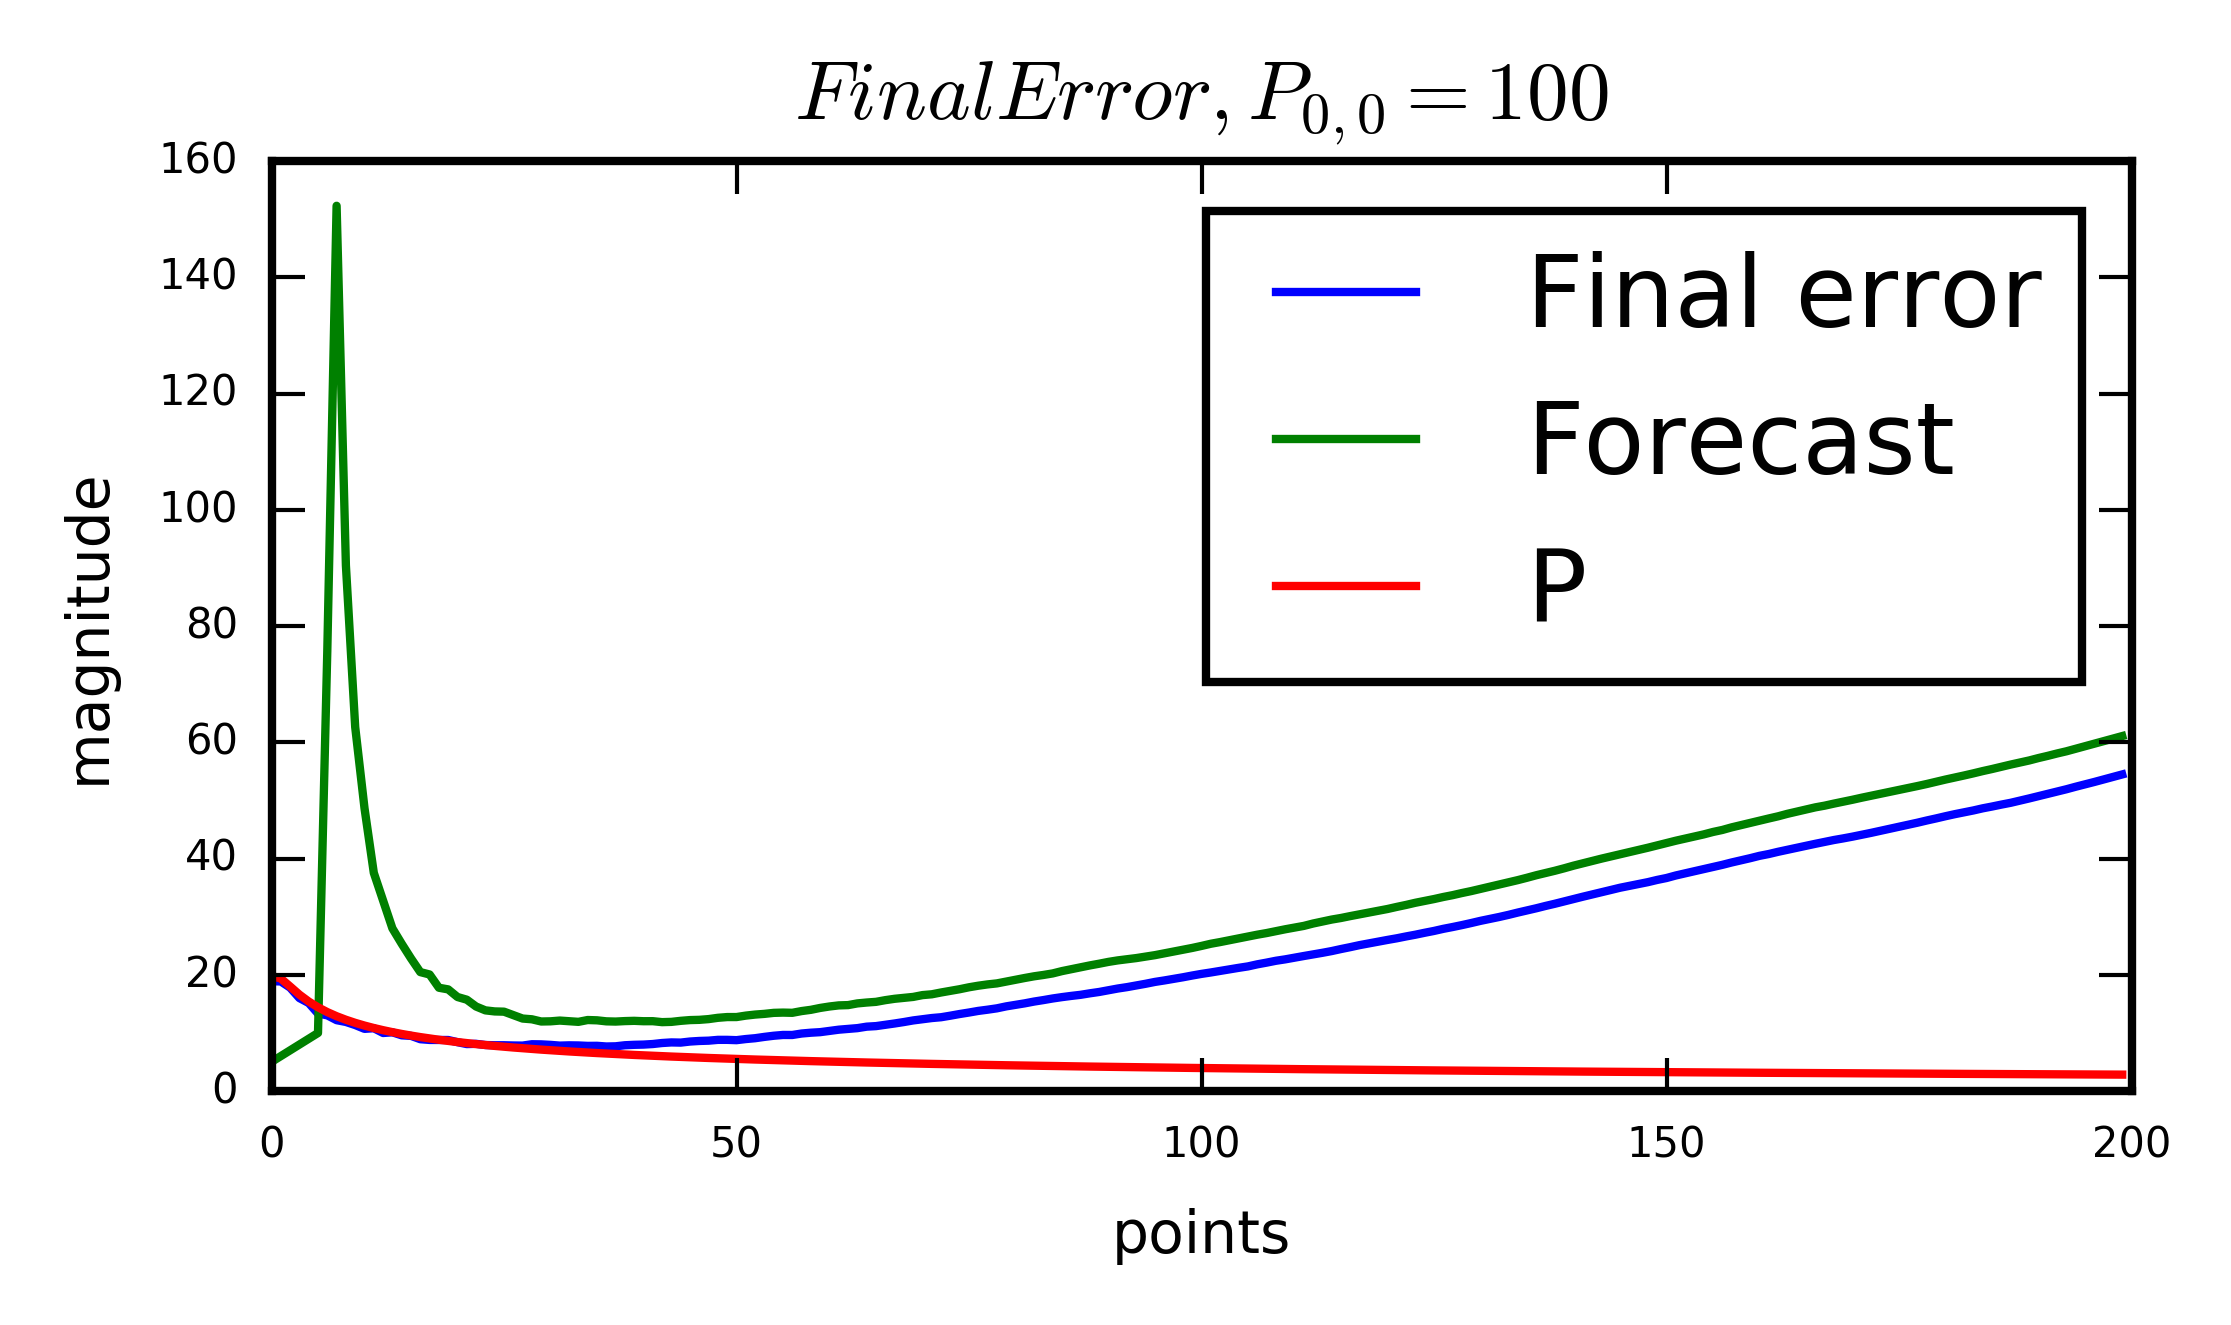

In [58]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi = 600)
ax.set_title('$FinalError$', fontsize = 10)
ax.plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'Final error')
plt.plot( (np.sum(ErrorXFore,axis=1)/(Repeats-1))**0.5,  label = 'Forecast')
ax.plot(range(N),P[:,0,0]**0.5,  label = 'P')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

## Error diverges when excluding state noise from Kalman filter
## it is important to use proper $\sigma_a$ to obtain good results

In [115]:
N=200
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)
sigma_a = 1
Q = G.dot(G.transpose())*sigma_a**2
x_1, z_1 = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
X_1, K_1, P_1, XF_1 = kalman(X_0, P_0, z, T, H, R, Q)
sigma_a = 0.2
Q = G.dot(G.transpose())*sigma_a**2

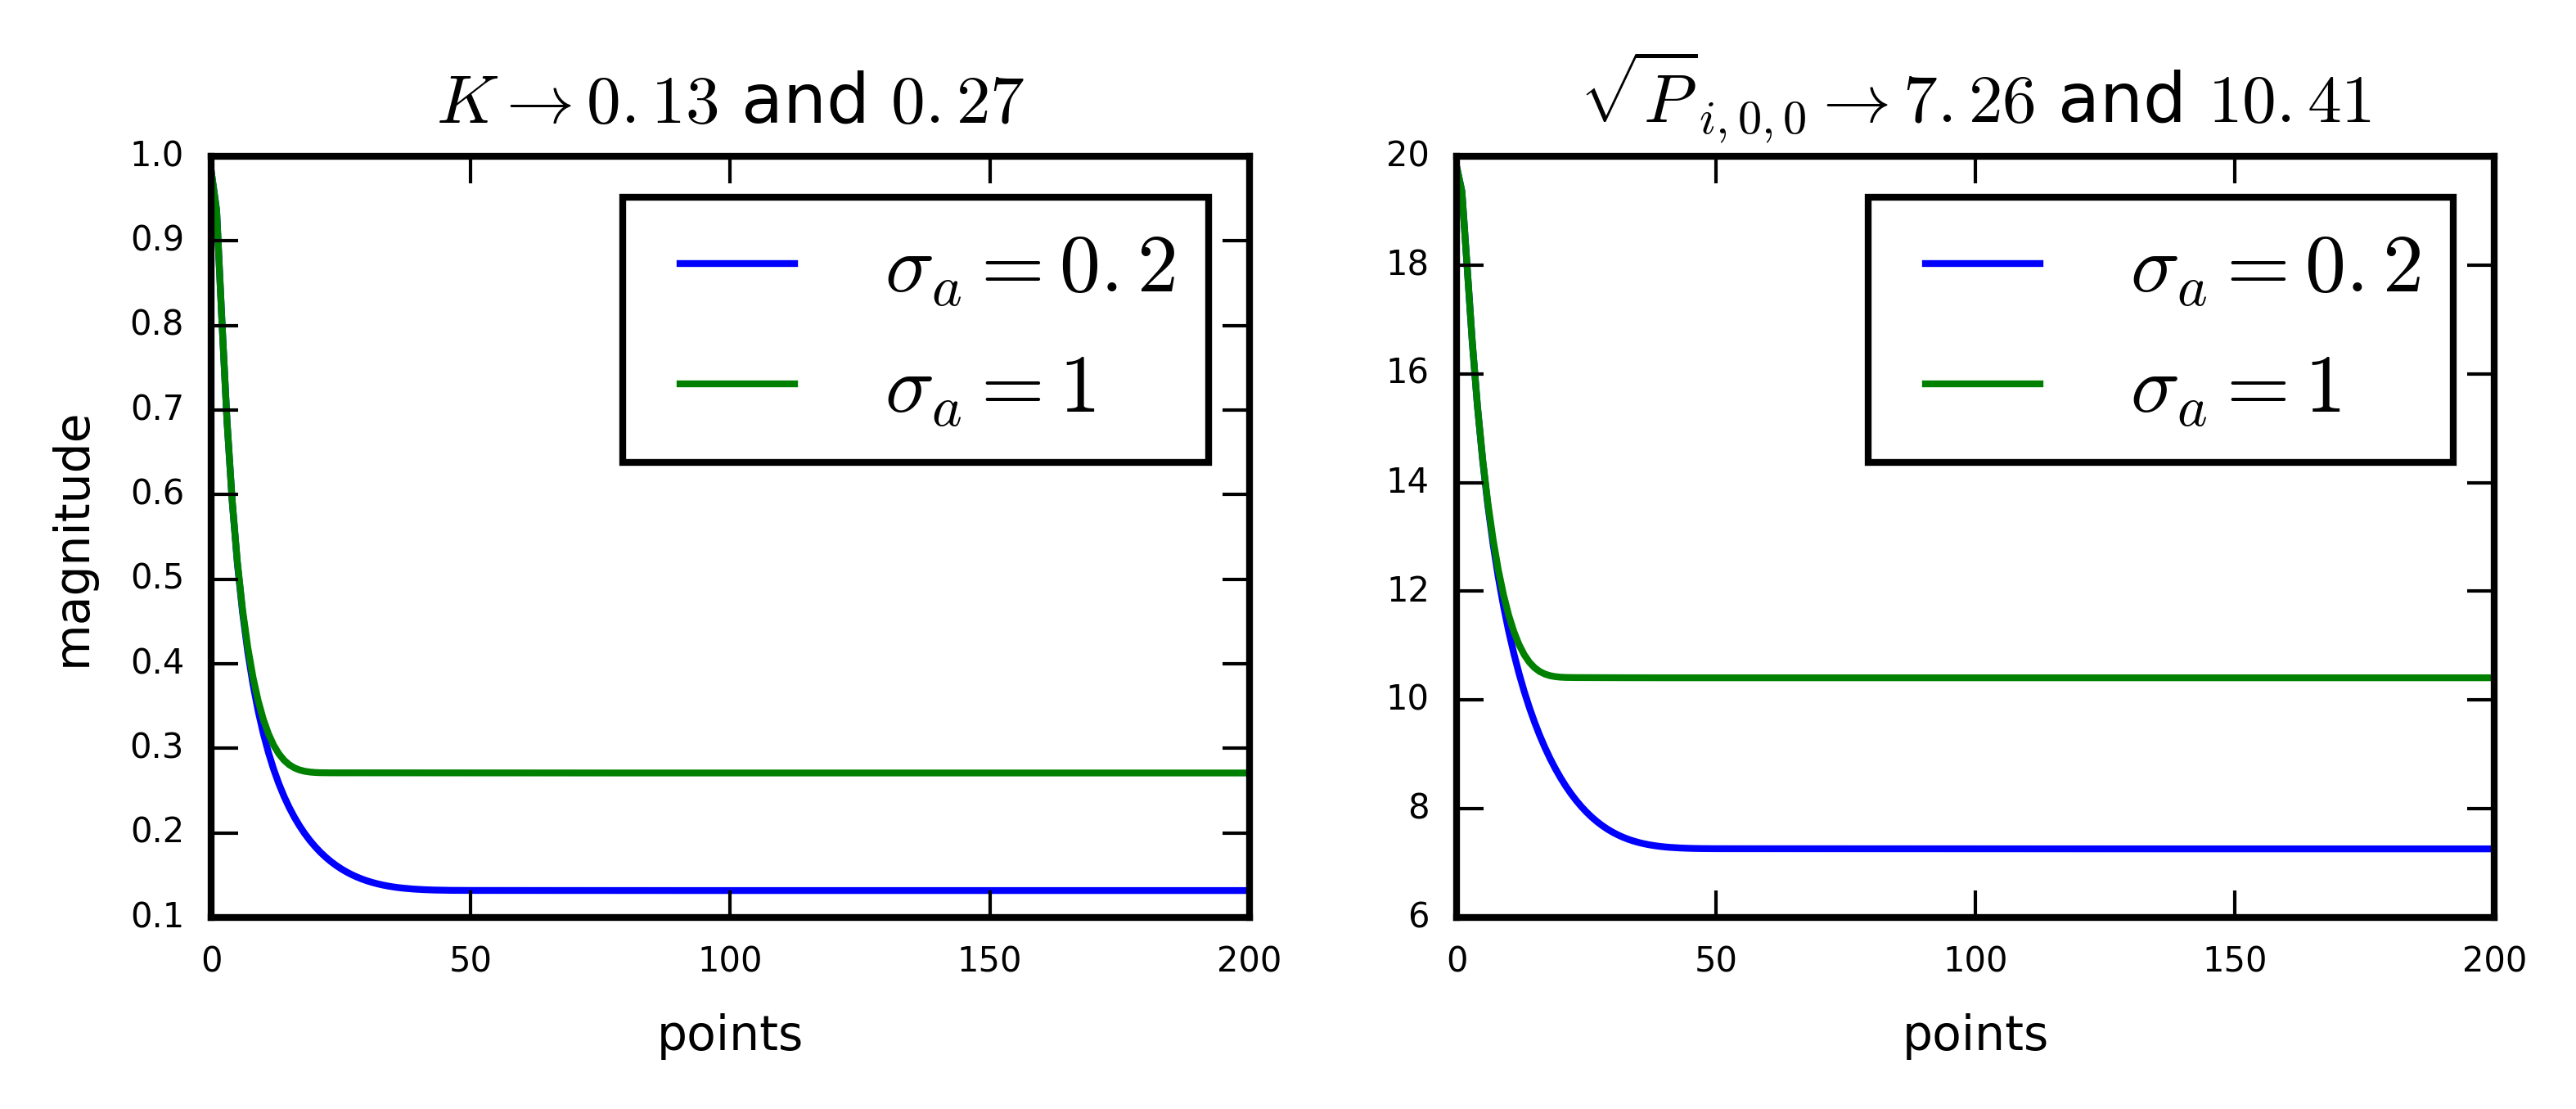

In [118]:
fig, ax = plt.subplots(1,2, figsize=(6,2), dpi = 600)
ax[0].set_title(r'$K \rightarrow %.2f$ and $%.2f$'%(np.average(K[N-50:N,0]), np.average(K_1[N-50:N,0])), fontsize = 10)
ax[0].plot(range(N),K[:,0].transpose()[0],label=r'$\sigma_a = 0.2$', linewidth = 1 )
ax[0].plot(range(N),K_1[:,0].transpose()[0],label=r'$\sigma_a = 1$', linewidth = 1 )
#ax.plot(range(N),np.average(K[100:N,0])*np.ones(N), 'b--', label = '$K_{stable} = %.2f$'%(np.average(K[100:N,0])) )
ax[1].set_title(r'$\sqrt{P}_{i,0,0} \rightarrow %.2f$ and $%.2f$' % (np.average(P[N-50:N,0,0]**0.5), np.average(P_1[N-50:N,0,0]**0.5)), fontsize = 10)
ax[1].plot(range(N),P[:,0,0]**0.5, label=r'$\sigma_a = 0.2$',)
ax[1].plot(range(N),P_1[:,0,0]**0.5, label=r'$\sigma_a = 1$')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].set_xlabel('points', fontsize = 7)
ax[1].set_xlabel('points', fontsize = 7)
ax[0].set_ylabel('magnitude', fontsize = 7);

## Higher $\frac{\sigma^2_w}{\sigma^2_n}$ leads to smaller time approaching to the constant level. However, that level of error is higher itself. So, (russian) "Pospeshish - lyudei nasmeshish"

# Investigating underestimated K

In [119]:
X_0 = np.array([[100],[5]])
sigma_a = 0.2
Q = G.dot(G.transpose())*sigma_a**2
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXNonOptTrue = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q, K/5)
    ErrorXNonOptTrue[:,i] = (x-X[:,0,0])**2
    if i % 50 == 0:
        print(i)
ErrorXOpt = (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5
ErrorXNonOpt = (np.sum(ErrorXNonOptTrue,axis=1)/(Repeats-1))**0.5

0
50
100
150
200
250
300
350
400
450


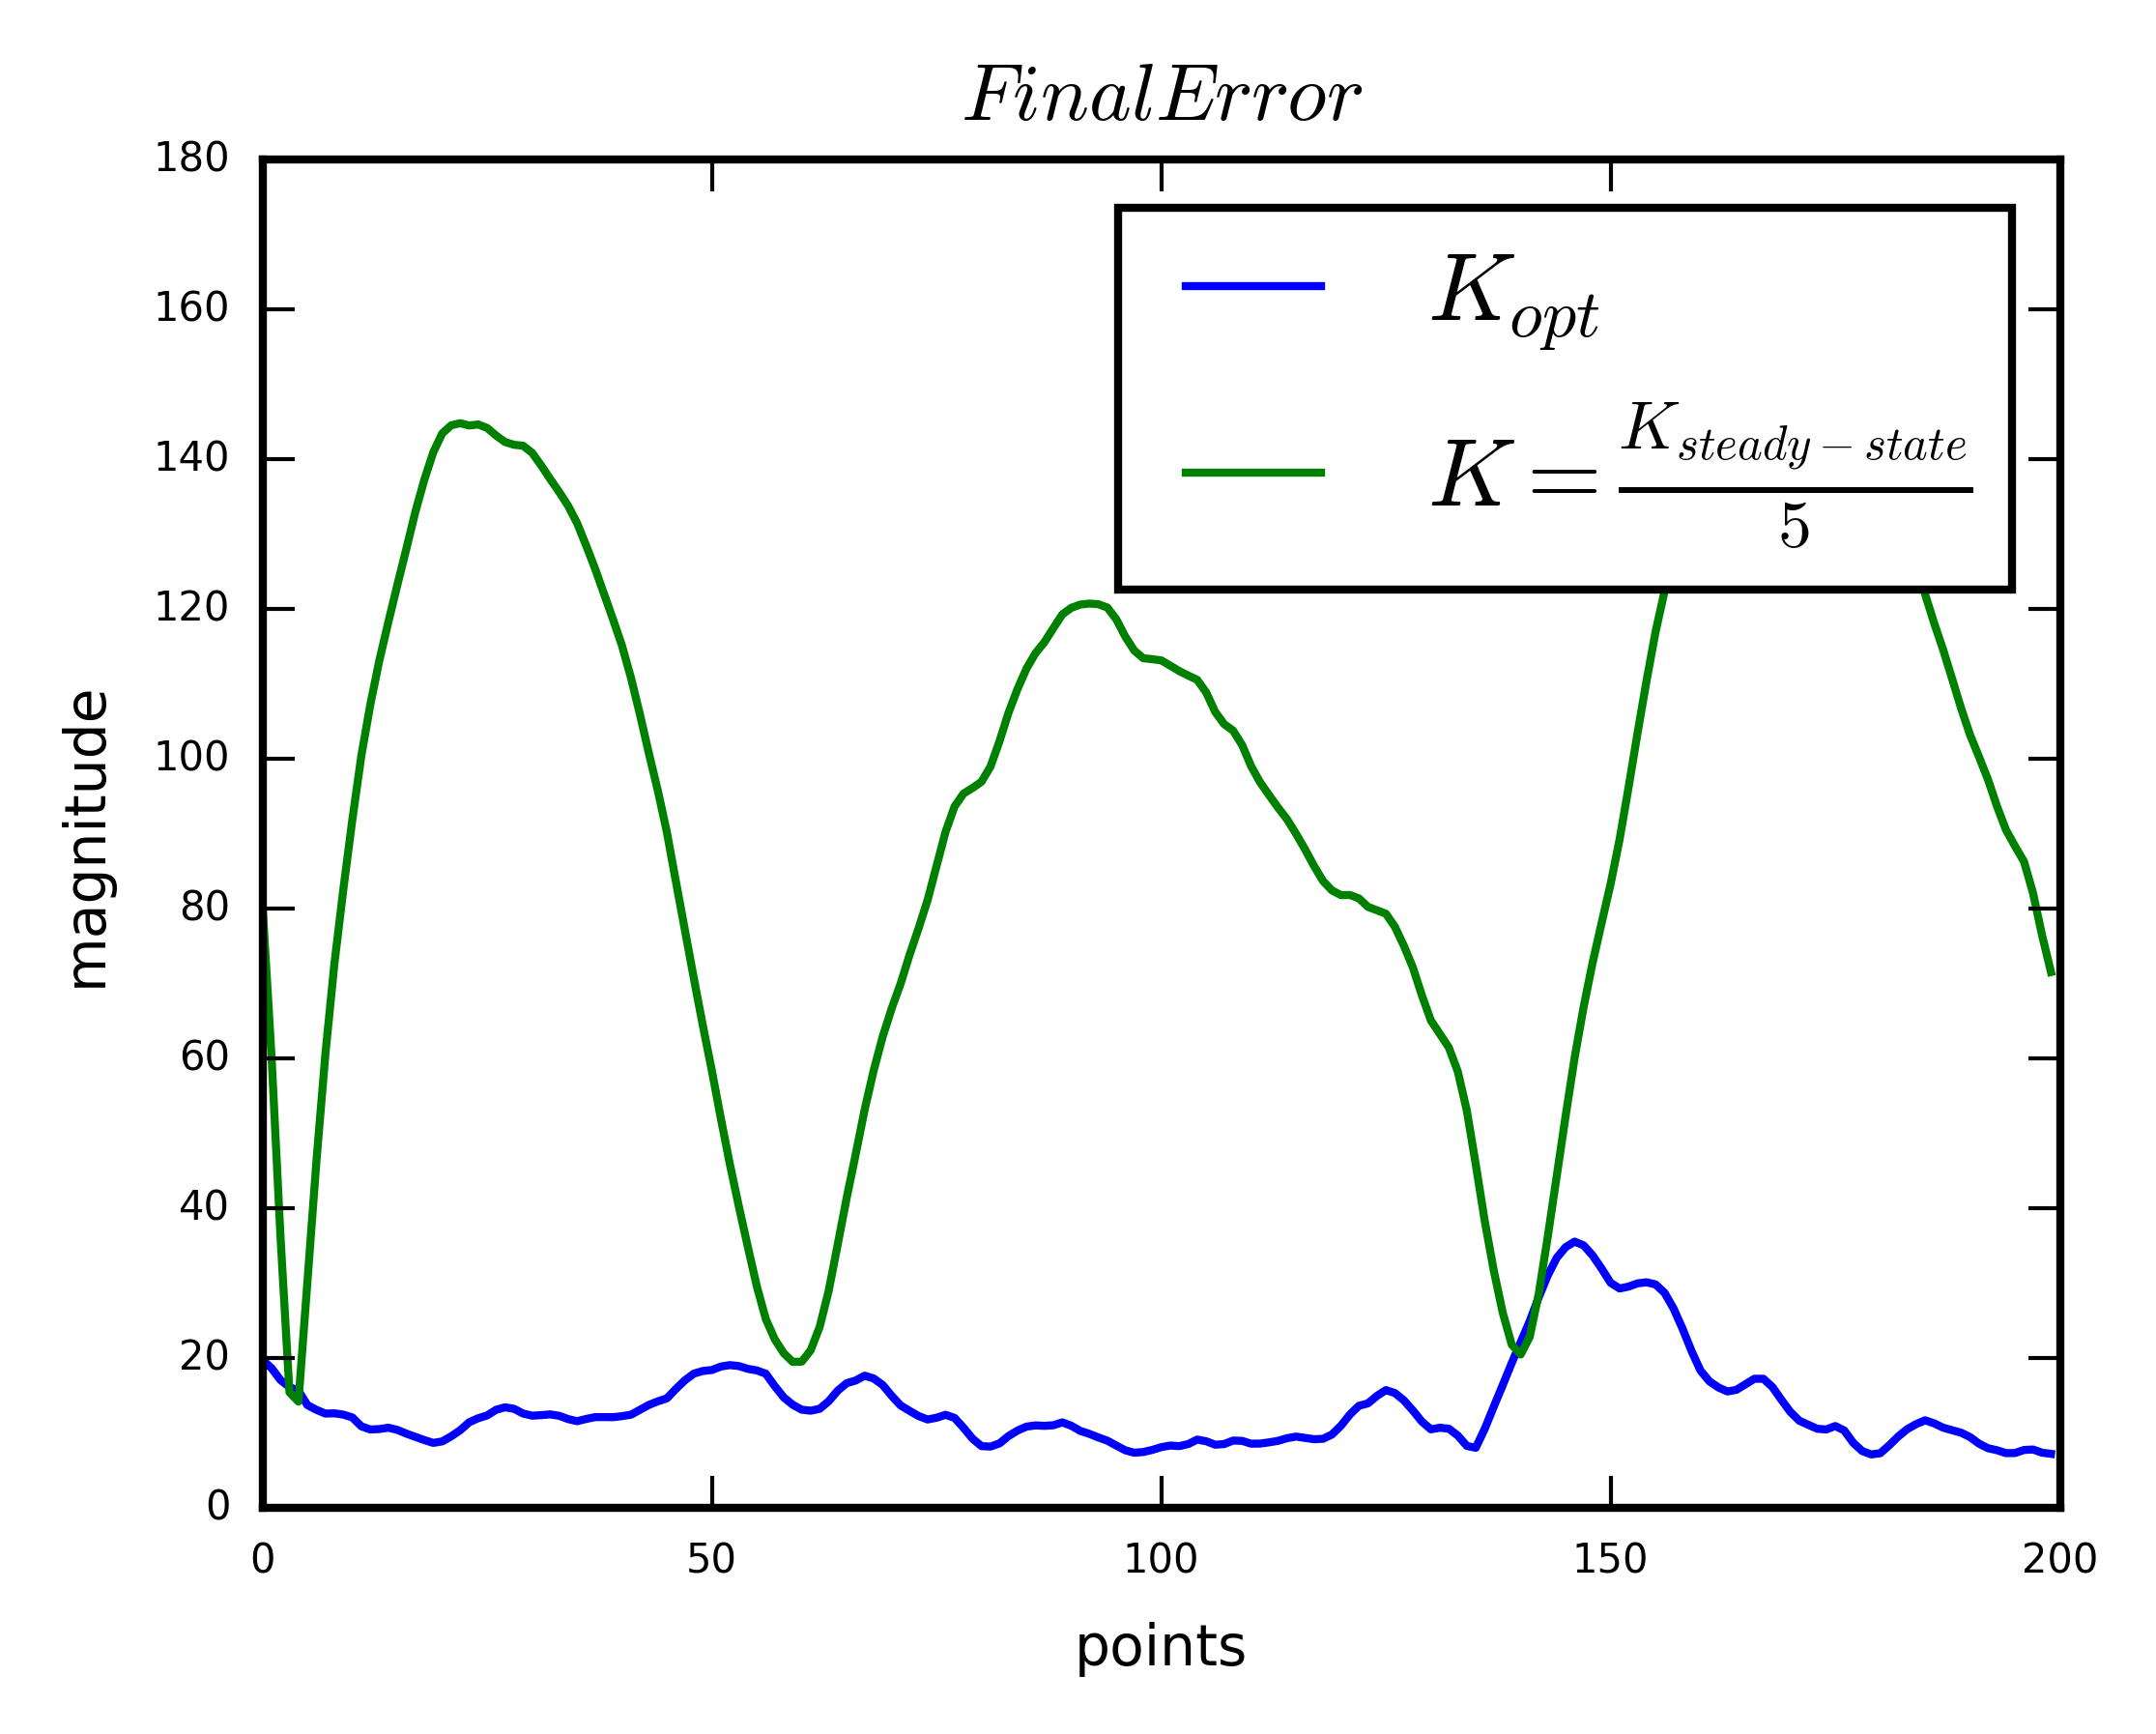

In [120]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi = 600)
ax.set_title('$FinalError$', fontsize = 10)
ax.plot( ErrorXOpt, label = r'$K_{opt}$')
ax.plot( ErrorXNonOpt,  label = r'$K = \frac{K_{steady-state}}{5}$')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

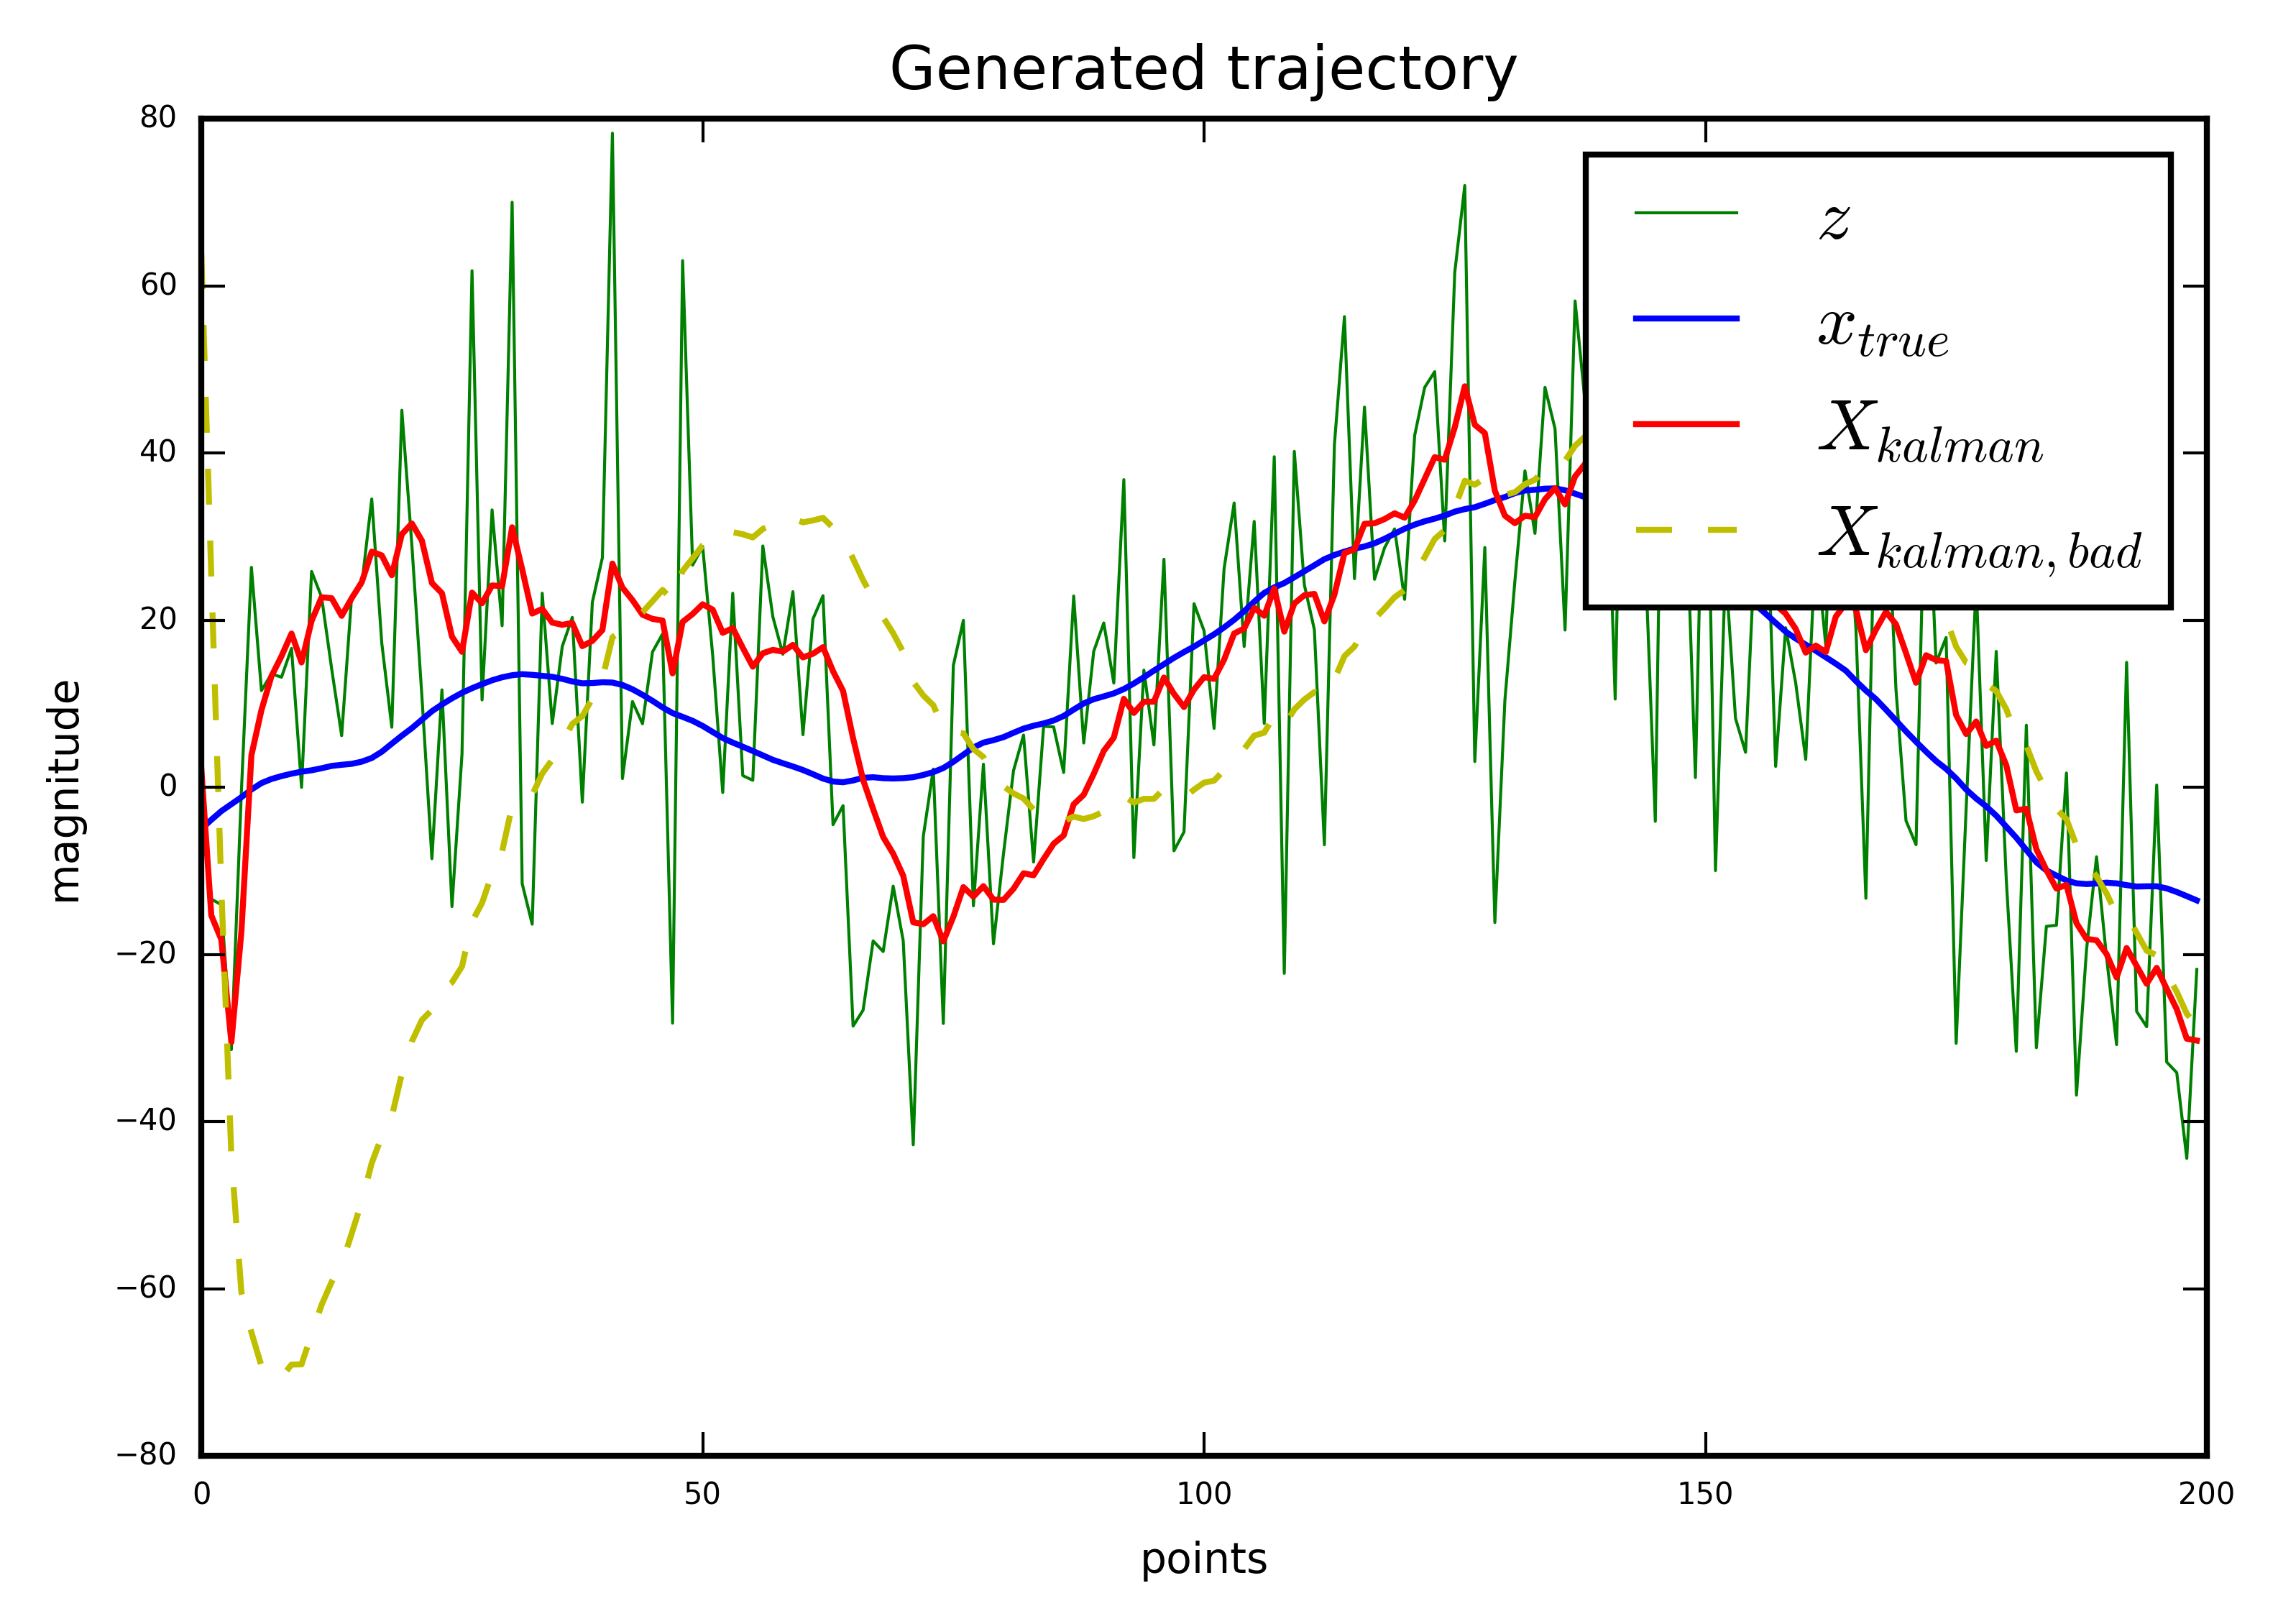

In [180]:
Ka = 1
N = 200
x_1 = -5
v_1 = 1
x, z = generate_acc_trajectory((Ka*sigma_a)**2, sigma_n**2, N, x_1, v_1, t)
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q*Ka**2)
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax.plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q*Ka**2, K/2.5)
ax.plot(range(N),X[:,0].transpose()[0],'y--', label = '$X_{kalman,bad}$', linewidth = 1 )

ax.legend(loc='upper right')

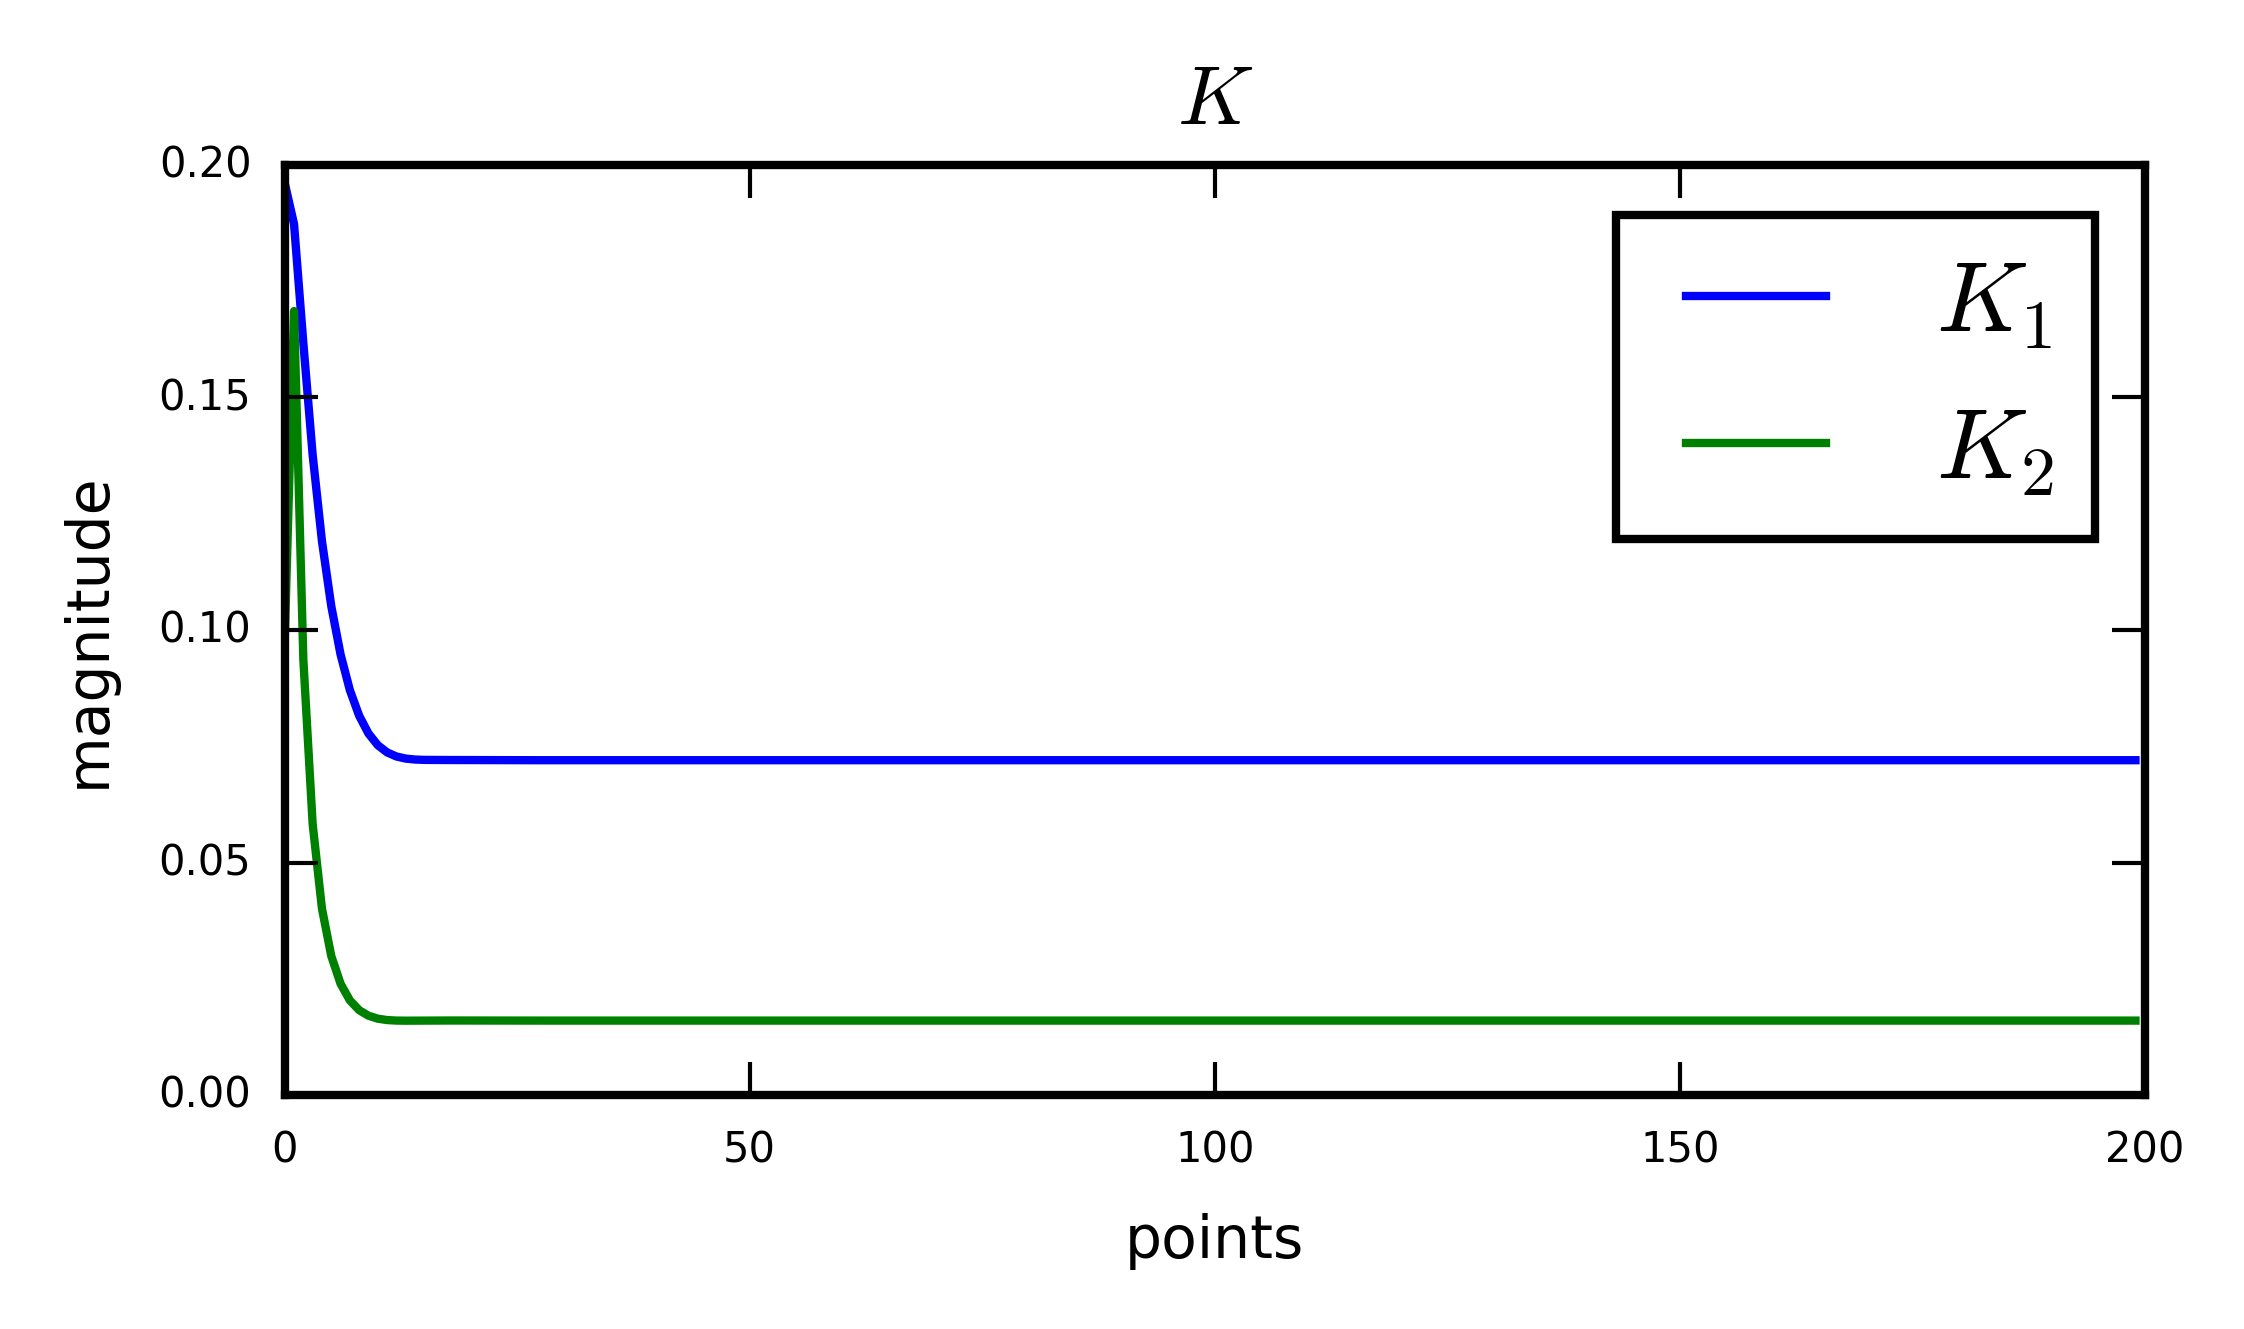

In [177]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi = 600)
ax.set_title('$K$', fontsize = 10)
ax.plot( range(N),K[:,0], label = '$K_1$')
ax.plot( range(N),K[:,1], label = '$K_2$')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

## Those oscillations appear due to $\delta v \simeq - K_2 \cdot x$ and thus their period can be estimated by $T \simeq \frac{2 \pi}{\sqrt{K_2}}$

In [189]:
K1 = K[-1,0]
K2 = K[-1,1]
T = 2*np.pi/np.sqrt(K2)[0]
T

102.92036180854936